In [24]:
# jupyter notebook adaptation of:
# A 165 LINE TOPOLOGY OPTIMIZATION CODE BY NIELS AAGE AND VILLADS EGEDE JOHANSEN, JANUARY 2013
from __future__ import division
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.pyplot as pplot
import cv2
from PIL import Image, ImageDraw, ImageFont


from scipy import signal

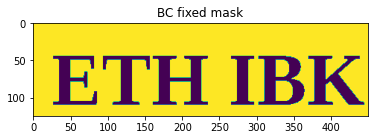

In [27]:
# Probably different in your machine (could also not work!)
#fnt = ImageFont.truetype("Pillow/Tests/fonts/FreeMono.ttf", 40)
#fnt = ImageFont.truetype(font = "/usr/share/fonts/truetype/adf/AccanthisADFStdNo2-Bold.otf", size = 100)
fnt = ImageFont.truetype(font = '/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf',size = 100)
img = Image. new('RGB', (450, 125), color = (0, 0, 0))
d = ImageDraw. Draw(img)
d. text((25,20), "ETH IBK", fill=(255,255,0),font = fnt)
img = np.array(img)
pplot.imshow(img)

I = img

loading_mask = np.zeros(I[:,:,0].shape)

def make_random_mask(nloadings = 50):
    rr = np.random.rand(nloadings,2)
    r1 = np.array((rr[:,0] * I.shape[0]), dtype = int)
    r2 = np.array((rr[:,1] * I.shape[1]), dtype = int)
    loading_mask[r1,r2] = 1;
    return loading_mask

mask = I[:,:,0]<200;

# This is going to be used for fixed (zero displacement) boundary conditions.
mask_constr = np.zeros(mask.shape)
mask_constr[:,-10:] = True;
mask_constr[-10:,:] = True;

pplot.imshow(mask);
pplot.title('BC fixed mask')
pplot.show()

# Image gradients are also used for boundary conditions:
mx = signal.convolve2d(mask,[[-1,-1, 1,1],
                          [-1,-1,1 ,1]],'same')

my = signal.convolve2d(mask,[[1,1, 1,1],
                          [-1,-1,-1 ,-1]],'same')
dxmask = np.abs(mx);




Text(0.5, 1.0, 'Fixed')

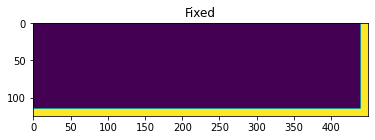

In [28]:
pplot.imshow(mask_constr)
pplot.title("Fixed")

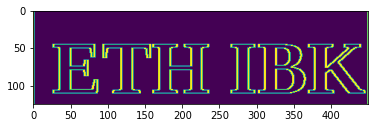

In [29]:
dont_shapeopt = (np.abs(my) + np.abs(mx)) > 0
pplot.imshow(dont_shapeopt)

In [30]:
I[:,:,0], I[:,:,1], I[:,:,2] = [dont_shapeopt, I[:,:,0], mask_constr]


## Constraints
You can use the pixel color values of an image to encode boundary conditions and constraints
Yellow means "don't optimize this" and blue means "zero displacement at this point" (constraint for instance w. penalty method or lagr. mults)

In [31]:
# MAIN DRIVER
# The real main driver
#f __name__ == "__main__":
# Default input parameters
nelx=I.shape[0]
nely=I.shape[1]
volfrac=0.4
rmin=5.4
penal=3.
ft=1 # ft==0 -> sens, ft==1 -> dens


In [32]:
#element stiffness matrix
def lk():
    E=1
    nu=0.3
    k=np.array([1/2-nu/6,1/8+nu/8,-1/4-nu/12,-1/8+3*nu/8,-1/4+nu/12,-1/8-nu/8,nu/6,1/8-3*nu/8])
    KE = E/(1-nu**2)*np.array([ [k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
    [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
    [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
    [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
    [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
    [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
    [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
    [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]] ]);
    return (KE)
# Optimality criterion
def oc(nelx,nely,x,volfrac,dc,dv,g):
    l1=0
    l2=1e9
    move=0.2
    # reshape to perform vector operations
    xnew=np.zeros(nelx*nely)
    while (l2-l1)/(l1+l2)>1e-3:
        lmid=0.5*(l2+l1)
        xnew[:]= np.maximum(0.0,np.maximum(x-move,np.minimum(1.0,np.minimum(x+move,x*np.sqrt(-dc/dv/lmid)))))
        gt=g+np.sum((dv*(xnew-x)))
        if gt>0 :
            l1=lmid
        else:
            l2=lmid
    return (xnew,gt)

In [33]:

print("Minimum compliance problem with OC")
print("ndes: " + str(nelx) + " x " + str(nely))
print("volfrac: " + str(volfrac) + ", rmin: " + str(rmin) + ", penal: " + str(penal))
print("Filter method: " + ["Sensitivity based","Density based"][ft])
# Max and min stiffness
Emin=1e-9
Emax=1.0
# dofs:
ndof = 2*(nelx+1)*(nely+1)
# Allocate design variables (as array), initialize and allocate sens.
x=volfrac * np.ones(nely*nelx,dtype=float)
xold=x.copy()
xPhys=x.copy()

Minimum compliance problem with OC
ndes: 125 x 450
volfrac: 0.4, rmin: 5.4, penal: 3.0
Filter method: Density based


In [34]:
g=0 # must be initialized to use the NGuyen/Paulino OC approach
dc=np.zeros((nely,nelx), dtype=float)
# FE: Build the index vectors for the for coo matrix format.
KE=lk()
edofMat=np.zeros((nelx*nely,8),dtype=int)
to_constr_img = []
loading_mask_vector_x = [];
loading_mask_vector_y = [];
for elx in range(nelx):
    for ely in range(nely):
        el = ely+elx*nely
        n1=(nely+1)*elx+ely
        n2=(nely+1)*(elx+1)+ely
        edofMat[el,:]=np.array([2*n1+2, 2*n1+3, 2*n2+2, 2*n2+3,2*n2, 2*n2+1, 2*n1, 2*n1+1])
        
        if mask_constr.flatten()[el]:
            to_constr_img.append(np.array([2*n1+2, 2*n1+3, 2*n2+2, 2*n2+3]))
            
        #if loading_mask_x.flatten()[el]:
        #    loading_mask_vector_x.append(np.array([2*n1+2, 2*n2+2,2*n2, 2*n1]));
            
        #if loading_mask_y.flatten()[el]:
        #    loading_mask_vector_y.append(np.array([2*n1+3, 2*n2+3,2*n2+1, 2*n1+1]));
            
# Construct the index pointers for the coo format
iK = np.kron(edofMat,np.ones((8,1))).flatten()
jK = np.kron(edofMat,np.ones((1,8))).flatten()
# Filter: Build (and assemble) the index+data vectors for the coo matrix format
nfilter=int(nelx*nely*((2*(np.ceil(rmin)-1)+1)**2))
iH = np.zeros(nfilter)
jH = np.zeros(nfilter)
sH = np.zeros(nfilter)
cc=0
for i in range(nelx):
    for j in range(nely):
        row=i*nely+j
        kk1=int(np.maximum(i-(np.ceil(rmin)-1),0))
        kk2=int(np.minimum(i+np.ceil(rmin),nelx))
        ll1=int(np.maximum(j-(np.ceil(rmin)-1),0))
        ll2=int(np.minimum(j+np.ceil(rmin),nely))
        for k in range(kk1,kk2):
            for l in range(ll1,ll2):
                col=k*nely+l
                fac=rmin-np.sqrt(((i-k)*(i-k)+(j-l)*(j-l)))
                iH[cc]=row
                jH[cc]=col
                sH[cc]=np.maximum(0.0,fac)
                cc=cc+1
# Finalize assembly and convert to csc format
H=coo_matrix((sH,(iH,jH)),shape=(nelx*nely,nelx*nely)).tocsc()    
Hs=H.sum(1)
# BC's and support
dofs=np.arange(2*(nelx+1)*(nely+1))
fixed=np.array(list(set(np.hstack(to_constr_img))), dtype = int);#np.union1d(dofs[0:2*(nely+1):2],np.array([2*(nelx+1)*(nely+1)-1]))
free=np.setdiff1d(dofs,fixed)

#loading_mask_vectors = [];
#loading_mask_vectors.append(np.unique(np.hstack(loading_mask_vector_x)))
#loading_mask_vectors.append(np.unique(np.hstack(loading_mask_vector_y)))

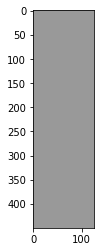

In [35]:
[elx_, ely_ ]  = np.meshgrid(range(0,mx.shape[0]),range(0,mx.shape[1]))
el = ely_+elx_*nely
n1=(nely+1)*elx_+ely_
n2=(nely+1)*(elx_+1)+ely_

#xdofs = [2*n1+2, 2*n1+3, 2*n2+2, 2*n2+3,2*n2, 2*n2+1, 2*n1, 2*n1+1]
#pplot.pcolor(xdofs[1])
#domain = mx.shape

xdofs = np.vstack([edofMat[:,k] for k in [0,2,4,6]]);
ydofs = np.vstack([edofMat[:,k] for k in [1,3,5,7]]);

#linindex = np.array([i for i in range(0, (nelx) * (nely))])
#print(xdofs.shape)

#print(linindex[-1]+1)#linindex.reshape(mx.shape[0]-1, mx.shape[1])


f=np.zeros((ndof,1))
f[xdofs[0,:]] = np.reshape(mx,[-1,1])
f[ydofs[0,:]] = np.reshape(my,[-1,1])

def mask_to_f(mask, val_x, val_y):
    els_set_dxmask = [i for i  in range(dxmask.flatten().shape[0]) if dxmask.flatten()[i] > 0]
    # for  the elements I want to set DOFs to some value, iterate over edofMat and find corr. DOFs.
    xdof_set_list = []
    ydof_set_list = []

    for e in els_set_dxmask:
        xdof_set_list.append(edofMat[e,0::2])
        ydof_set_list.append(edofMat[e,1::2])

    xdofs_set = np.unique(np.vstack(xdof_set_list).flatten())
    ydofs_set = np.unique(np.vstack(xdof_set_list).flatten())
    f=np.zeros((ndof,1))
    if type(val_x) is not float:
        
        f[xdofs_set,0] = val_x.flatten()[xdofs_set]
    else:
        f[ydofs_set,0] = val_y
    
    if type(val_y) is not float:
        f[xdofs_set,0] = val_y.flatten()[ydofs_set]
    else:
        f[ydofs_set,0] = val_y
        
    return f


u=np.zeros((ndof,1))
# Set load
#f[1,0]=-1
# Initialize plot and plot the initial design
plt.ion() # Ensure that redrawing is possible
fig,ax = plt.subplots()
im = ax.imshow(-xPhys.reshape((nelx,nely)).T, cmap='gray',\
interpolation='none',norm=colors.Normalize(vmin=-1,vmax=0))



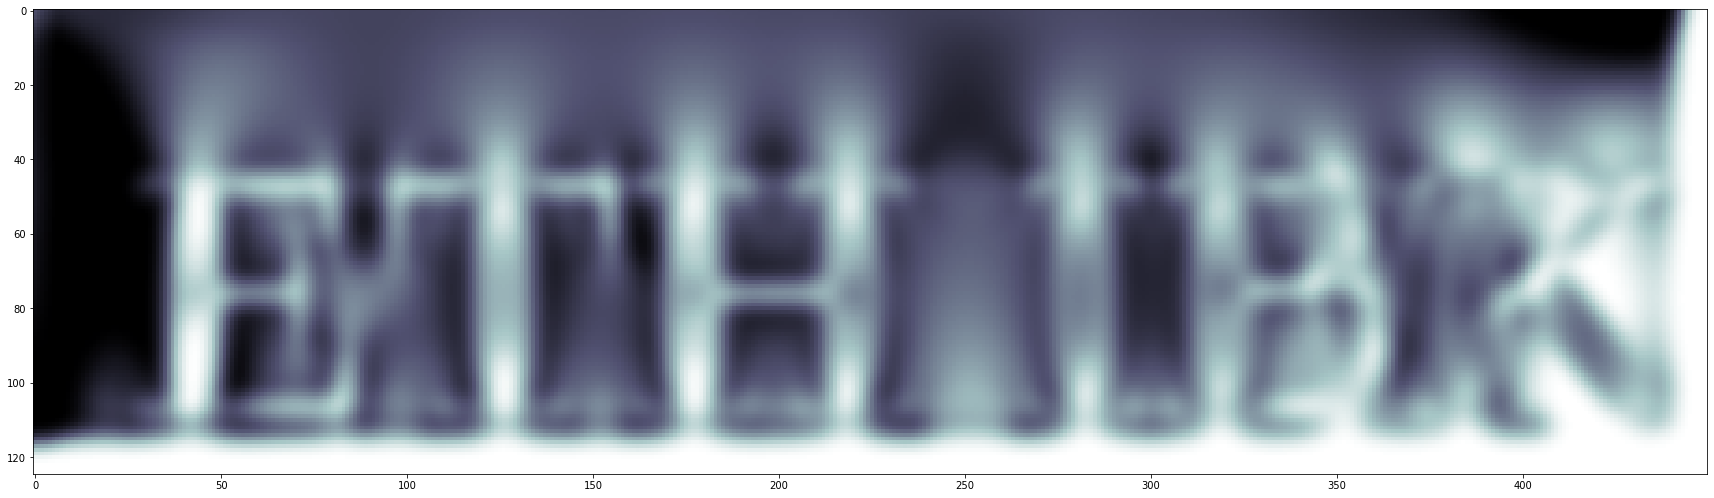

it.: 1 , obj.: 28758527.348 Vol.: 0.400, ch.: 0.200


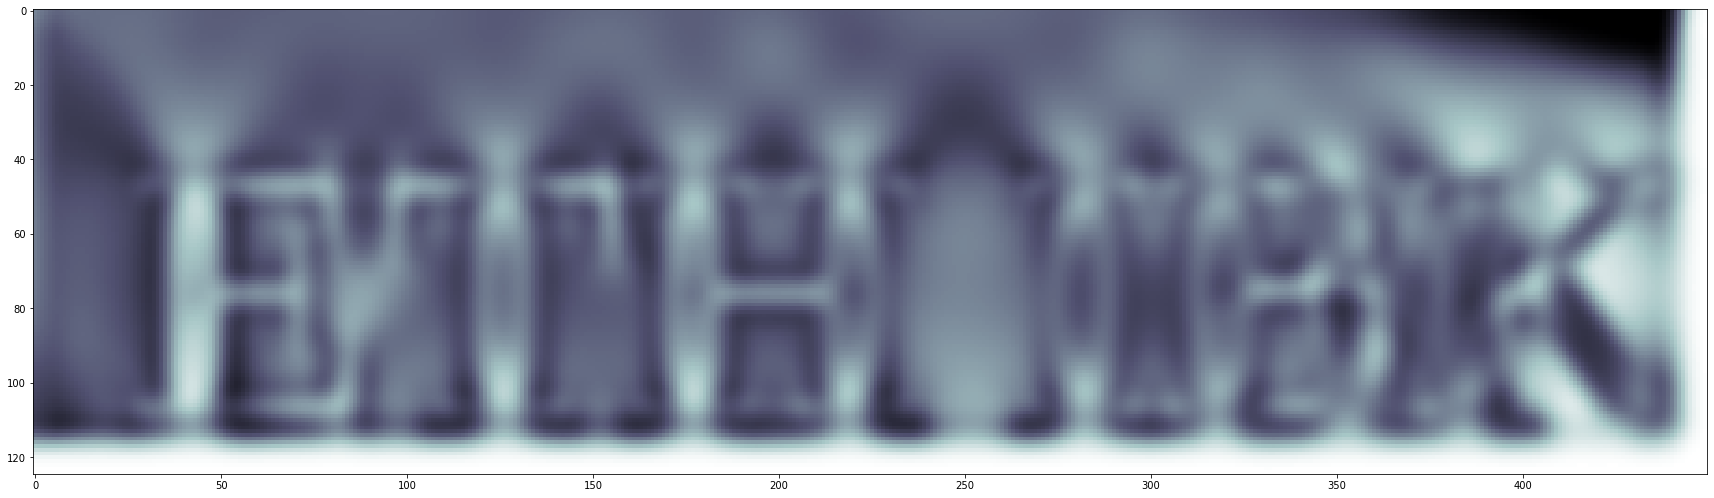

it.: 2 , obj.: 21733101.458 Vol.: 0.400, ch.: 0.200


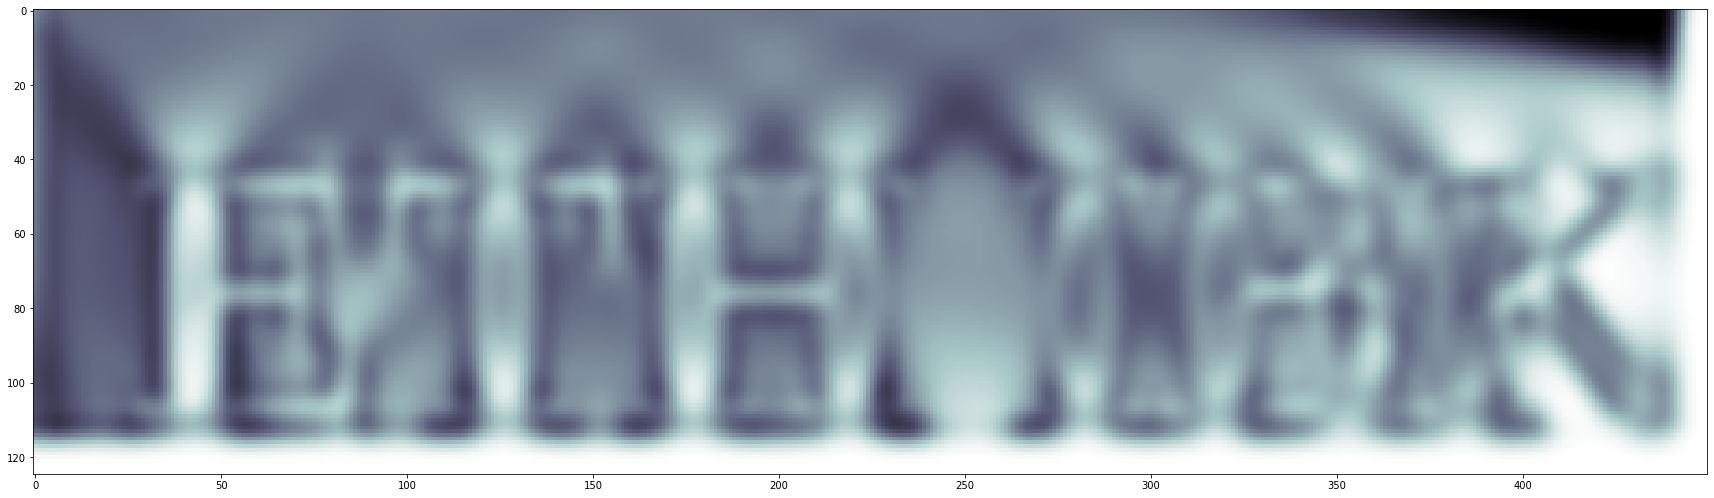

it.: 3 , obj.: 17930296.992 Vol.: 0.400, ch.: 0.200


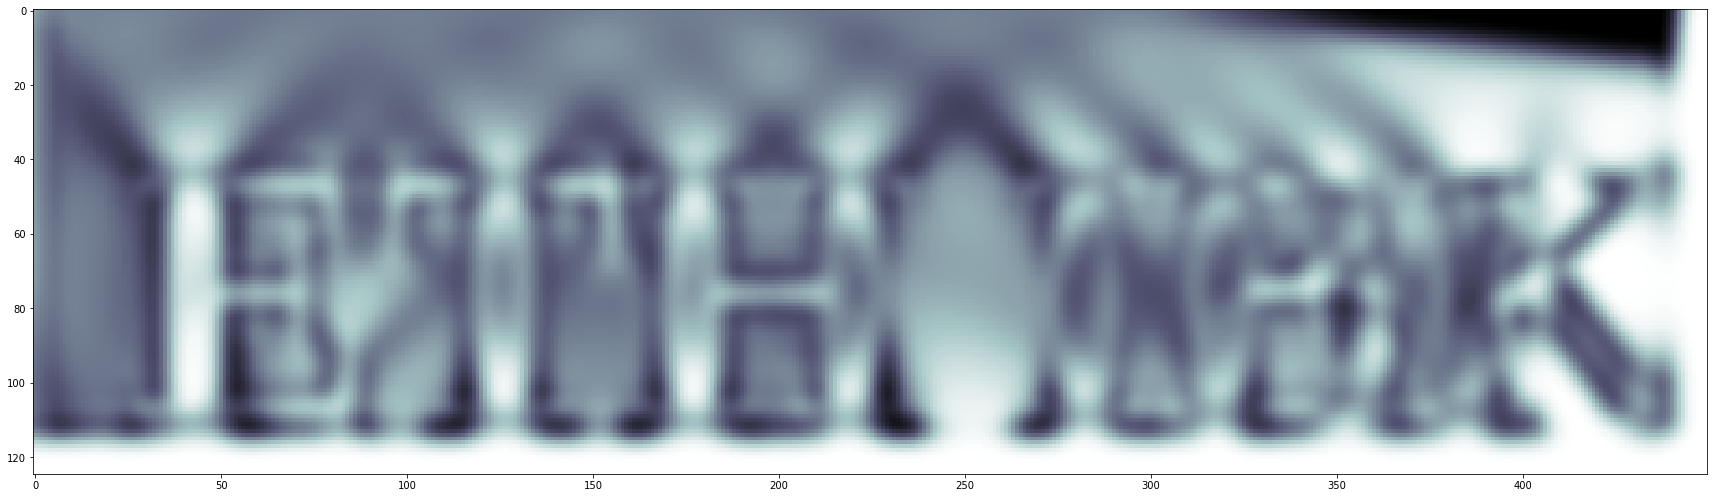

it.: 4 , obj.: 16161018.799 Vol.: 0.400, ch.: 0.200


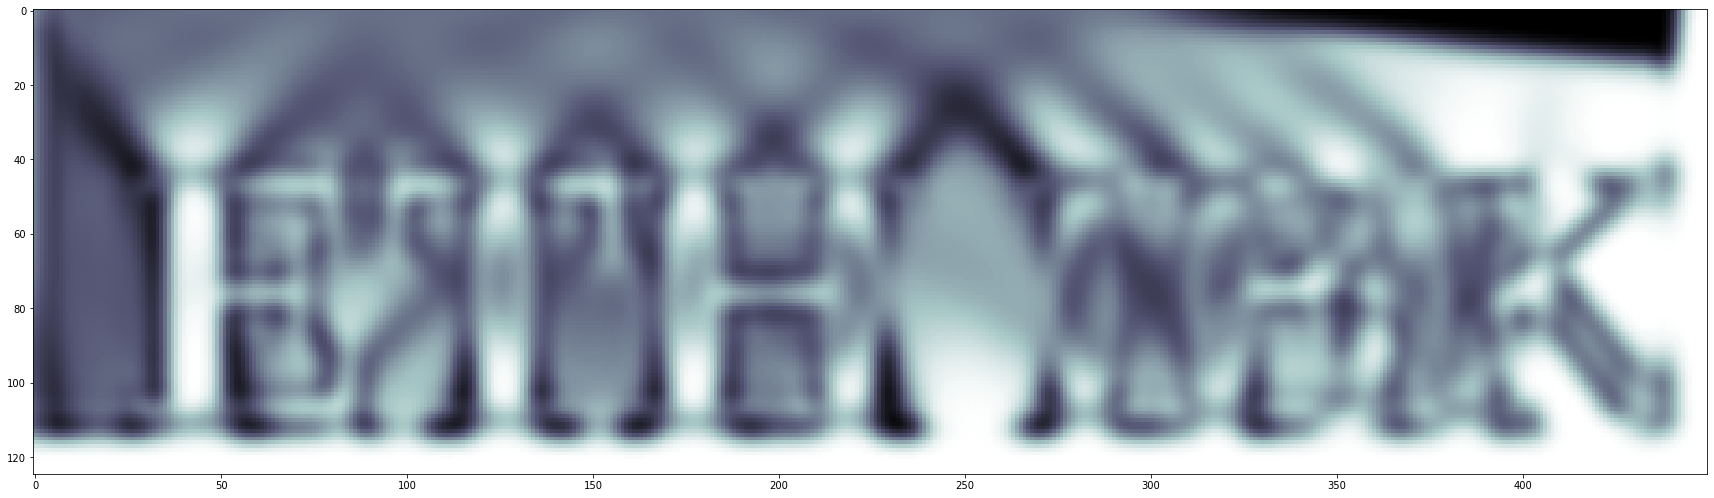

it.: 5 , obj.: 14821362.236 Vol.: 0.400, ch.: 0.200


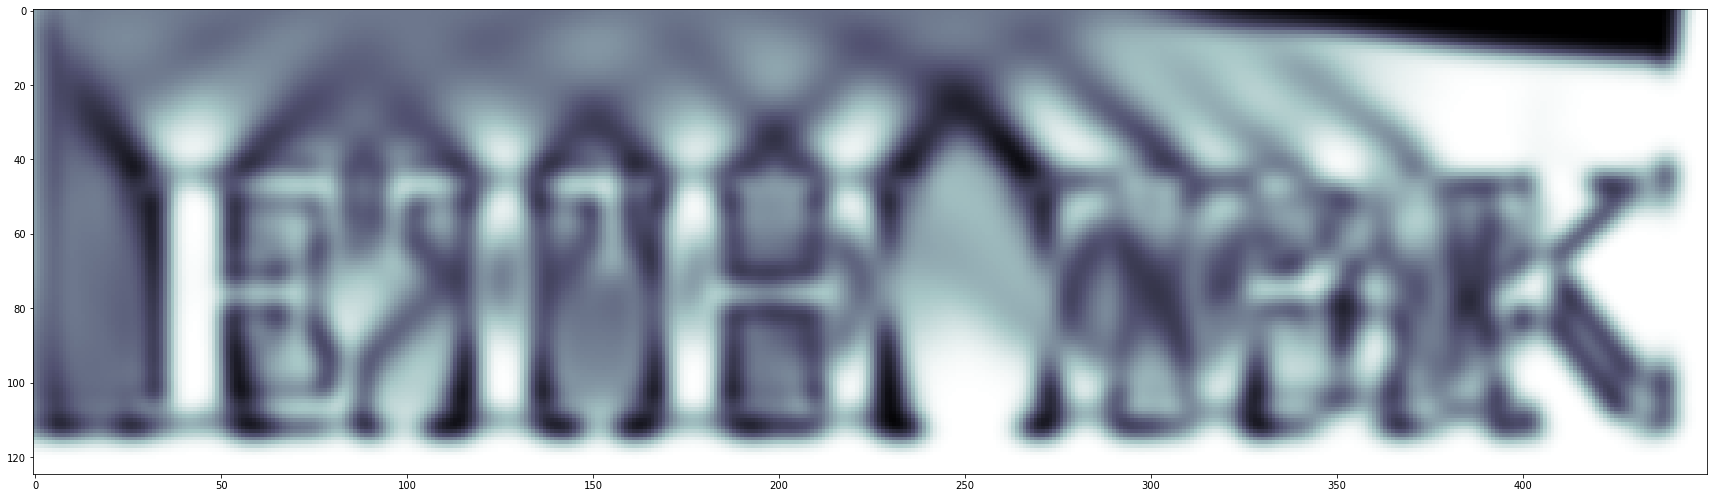

it.: 6 , obj.: 13885288.651 Vol.: 0.400, ch.: 0.200


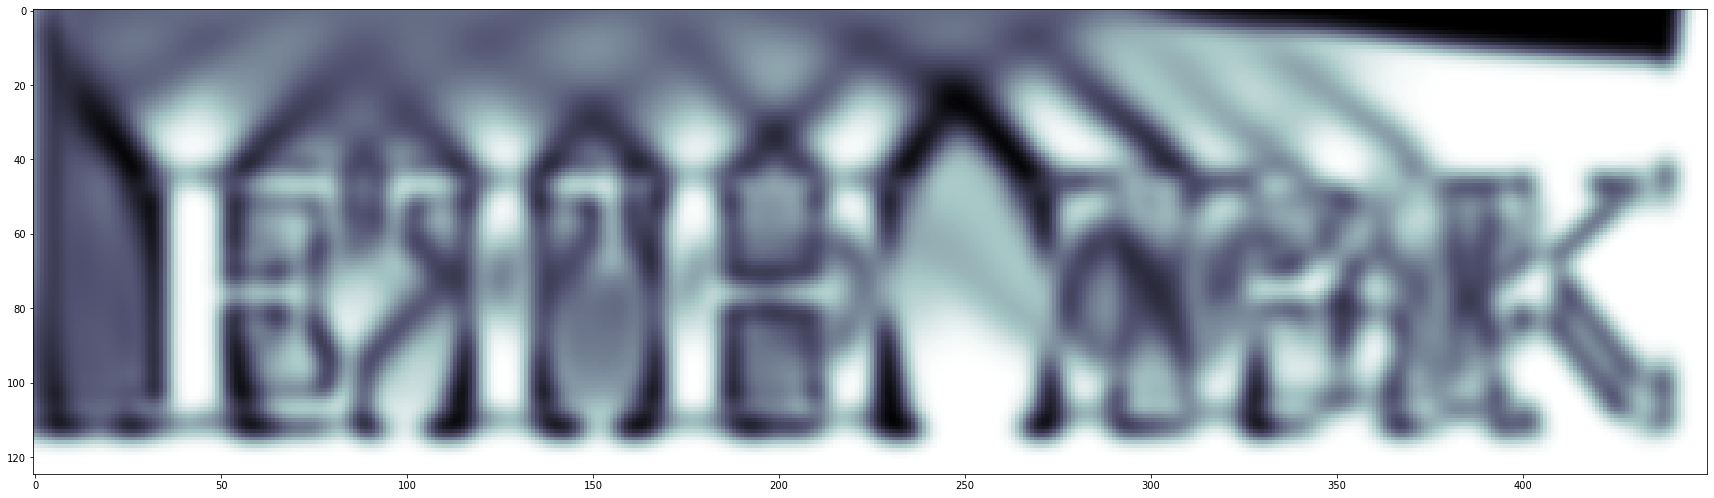

it.: 7 , obj.: 13224835.448 Vol.: 0.400, ch.: 0.200


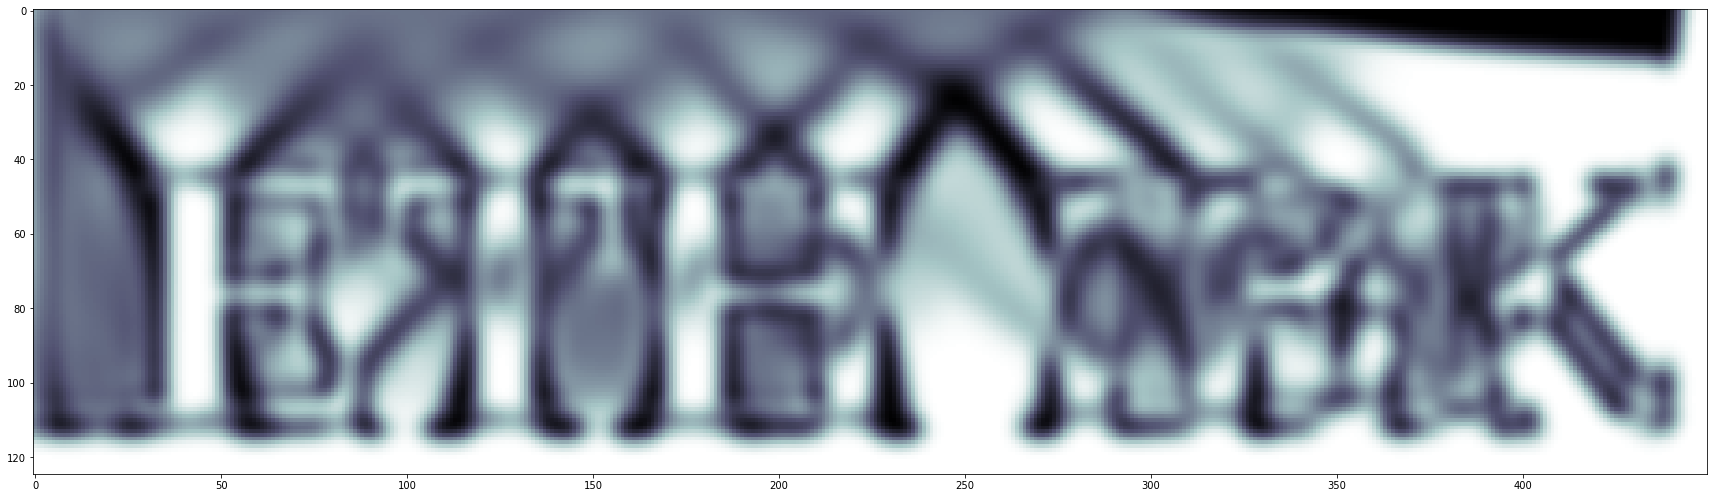

it.: 8 , obj.: 12677002.634 Vol.: 0.400, ch.: 0.200


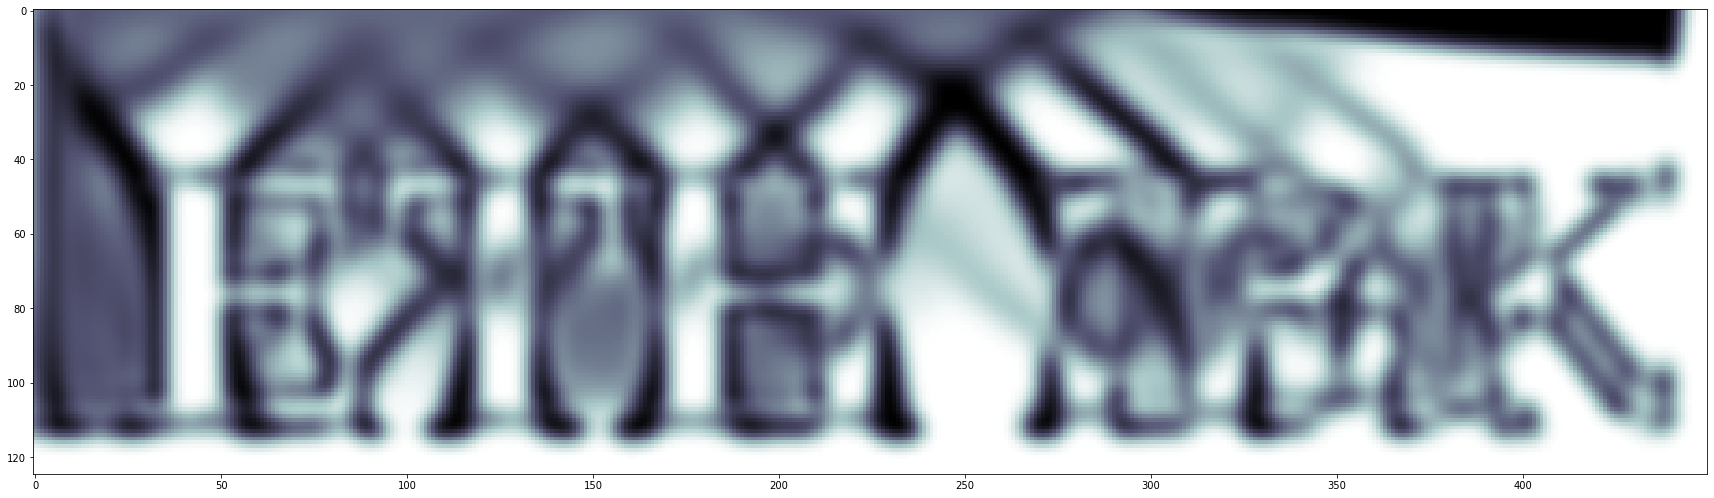

it.: 9 , obj.: 12191781.372 Vol.: 0.400, ch.: 0.200


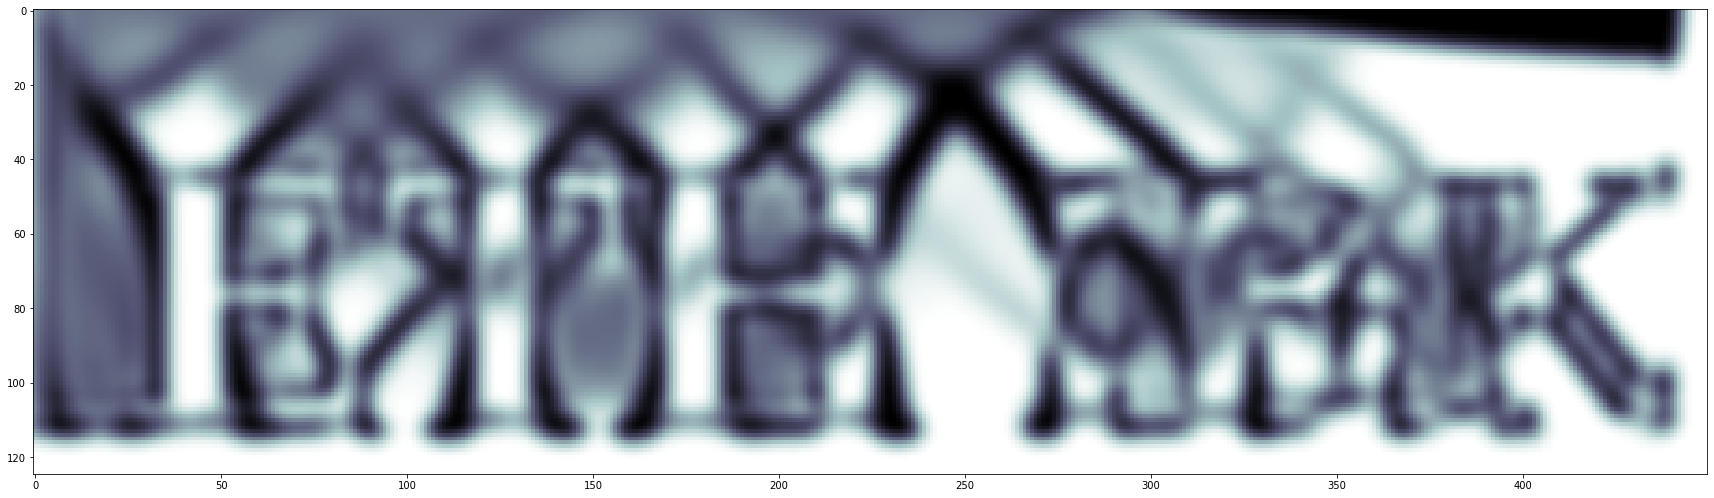

it.: 10 , obj.: 11755326.873 Vol.: 0.400, ch.: 0.200


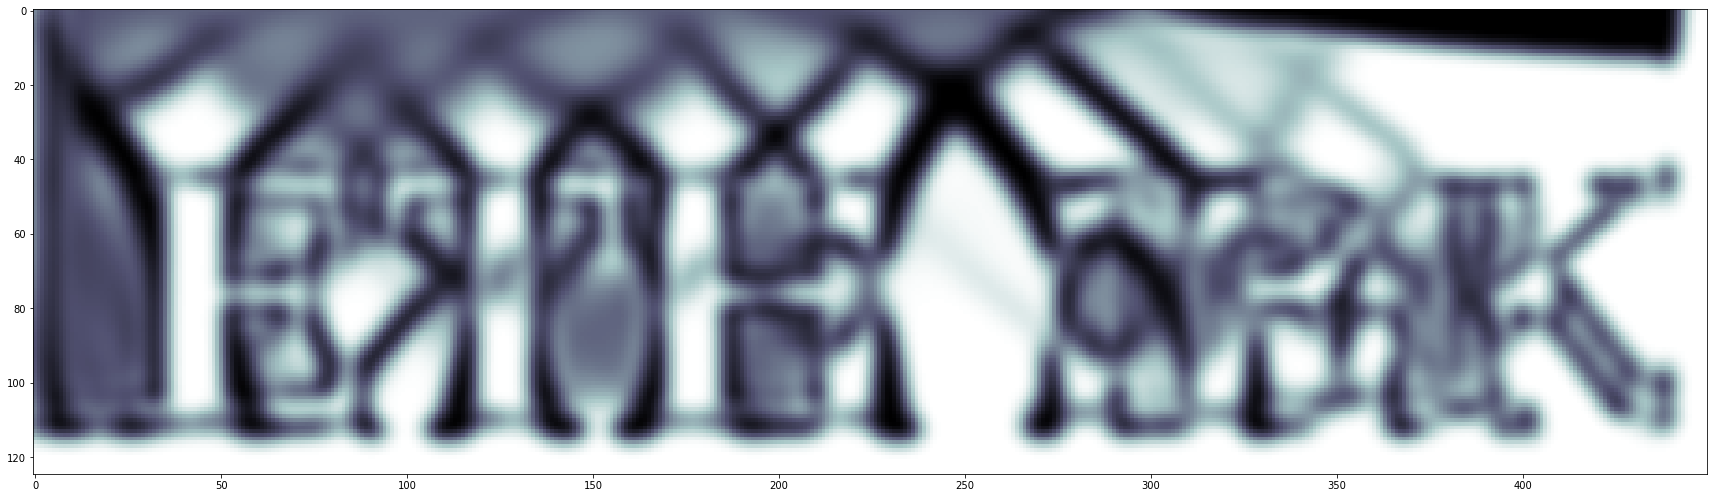

it.: 11 , obj.: 11357999.010 Vol.: 0.400, ch.: 0.200


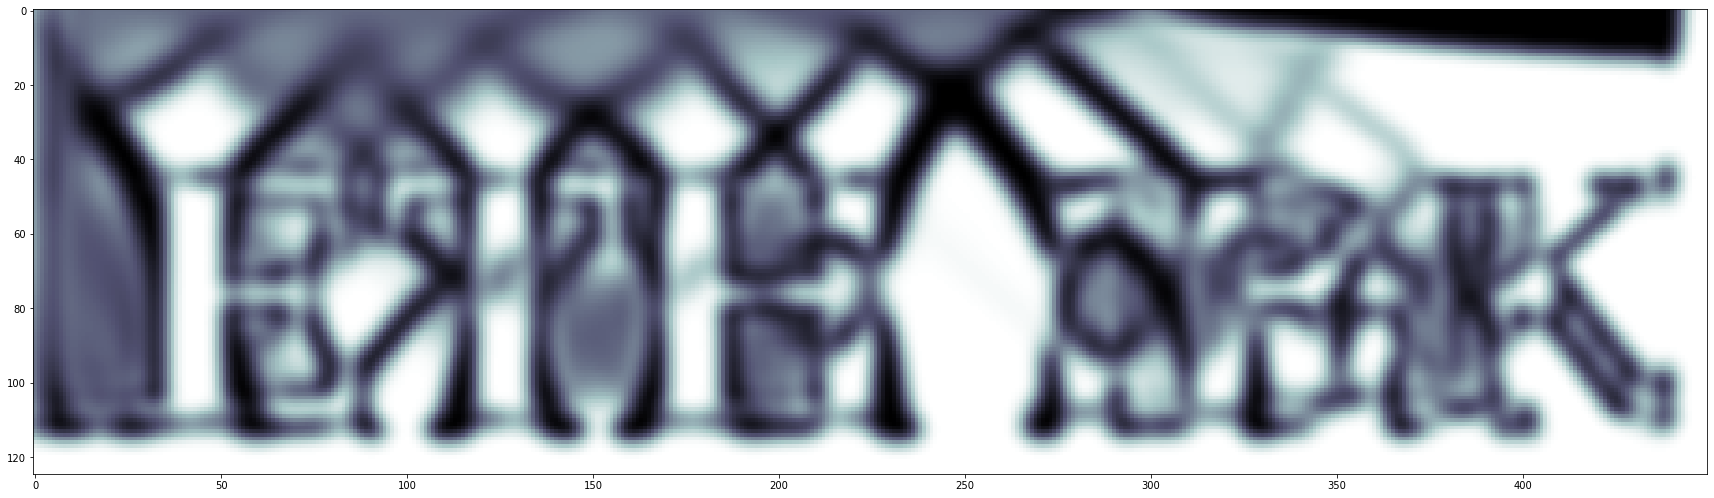

it.: 12 , obj.: 11003635.472 Vol.: 0.400, ch.: 0.200


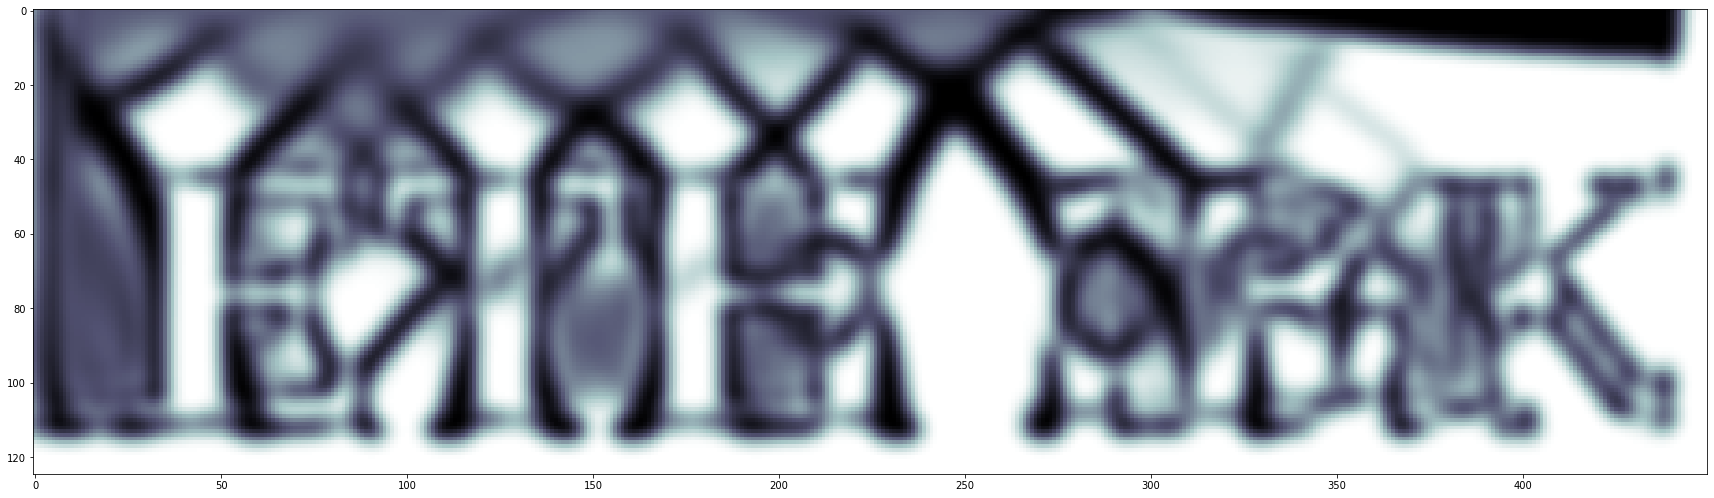

it.: 13 , obj.: 10706054.137 Vol.: 0.400, ch.: 0.188


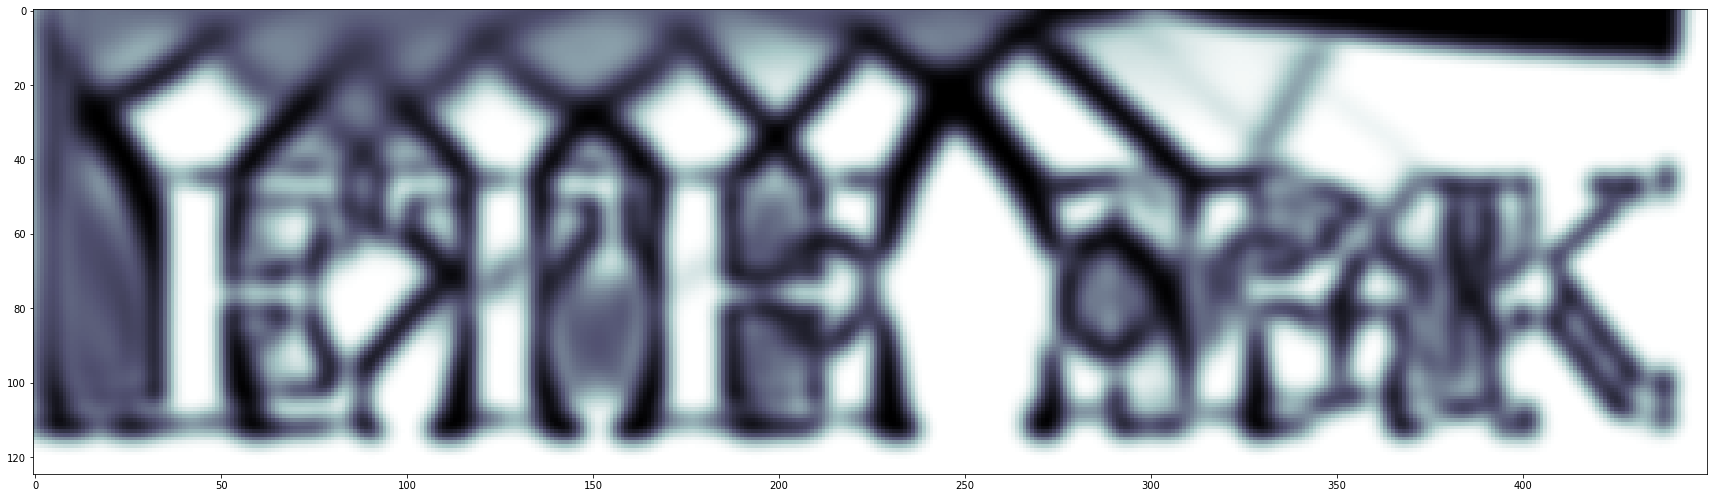

it.: 14 , obj.: 10484151.948 Vol.: 0.400, ch.: 0.193


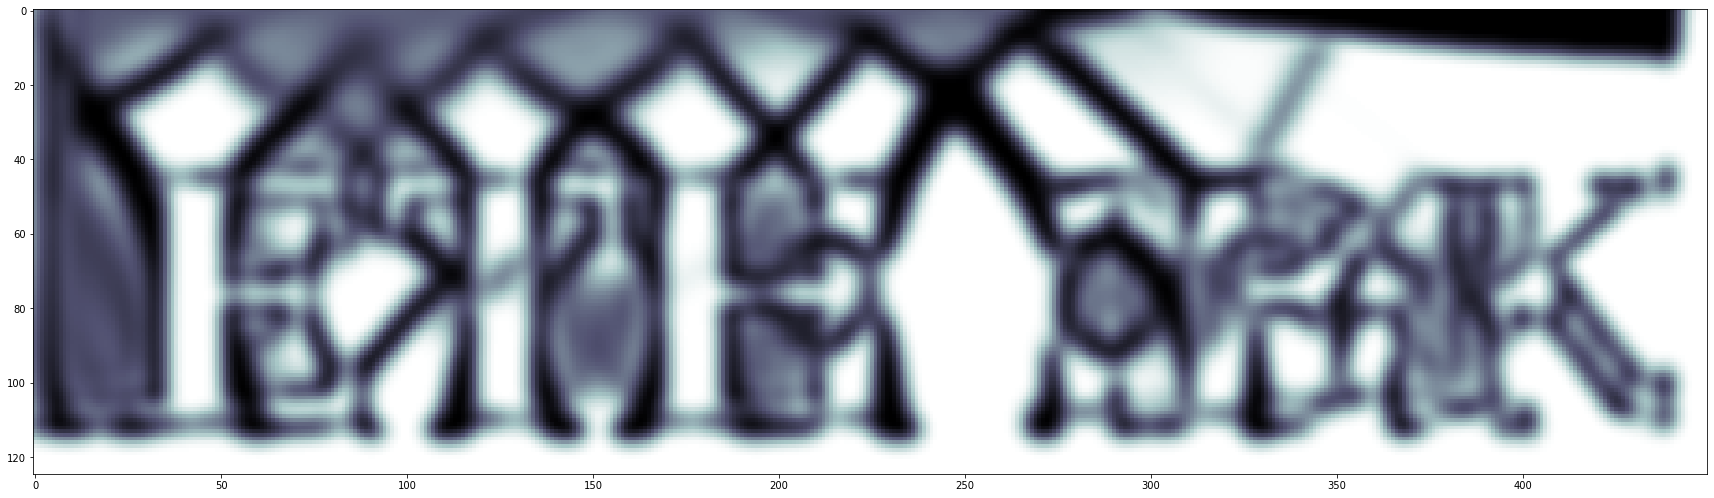

it.: 15 , obj.: 10285360.667 Vol.: 0.400, ch.: 0.182


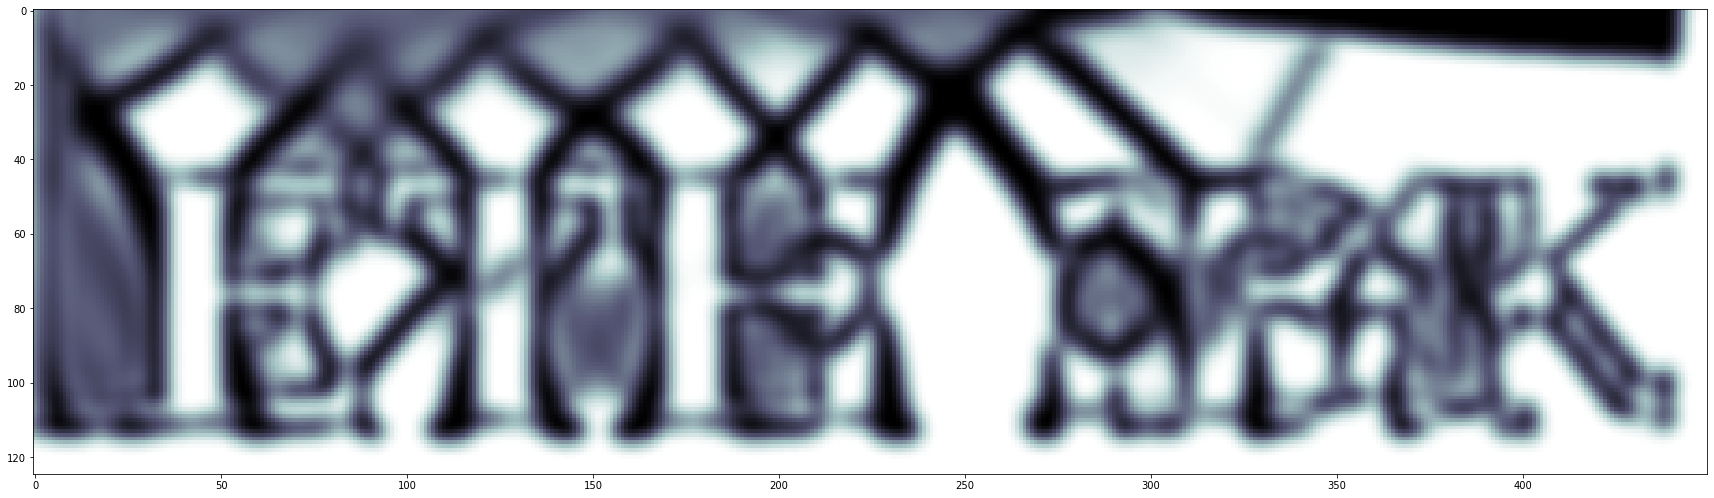

it.: 16 , obj.: 10122565.379 Vol.: 0.400, ch.: 0.176


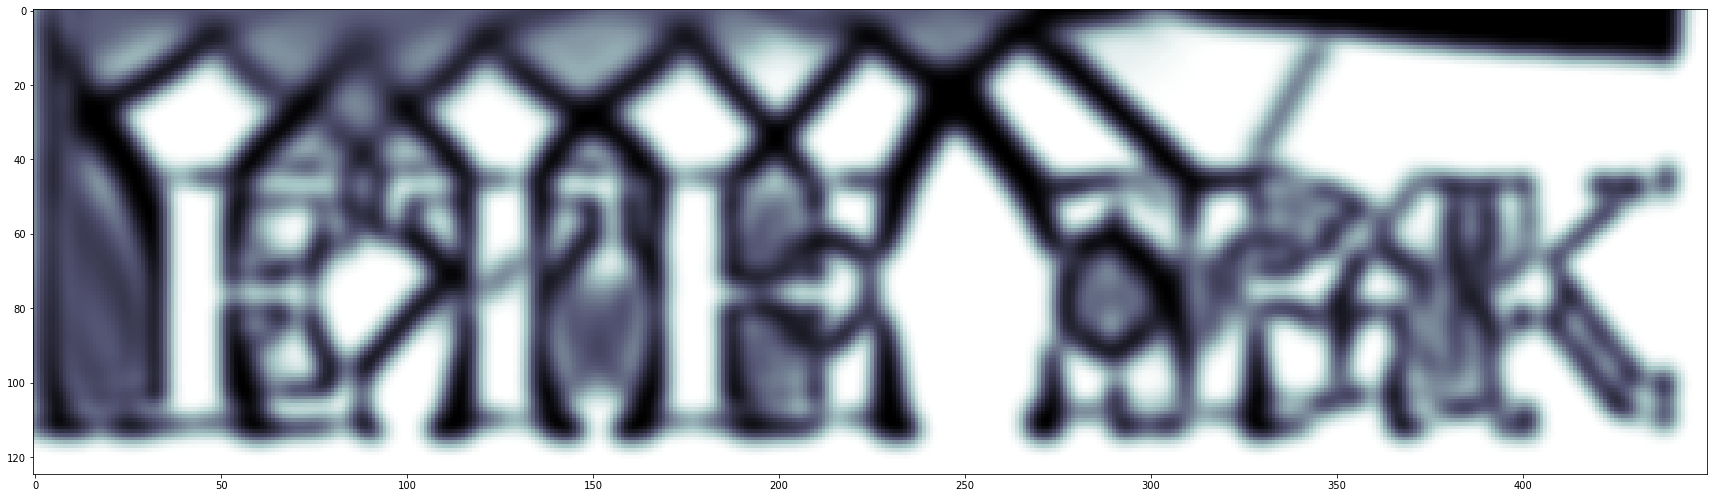

it.: 17 , obj.: 9983592.306 Vol.: 0.400, ch.: 0.172


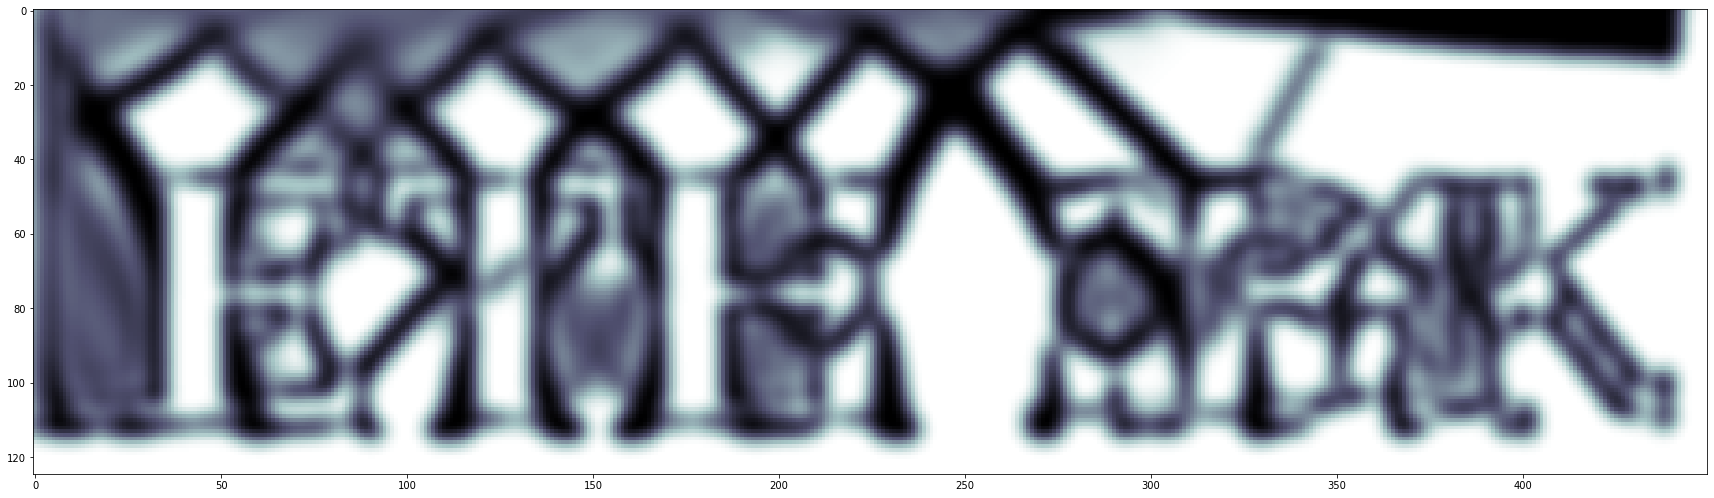

it.: 18 , obj.: 9877352.173 Vol.: 0.400, ch.: 0.169


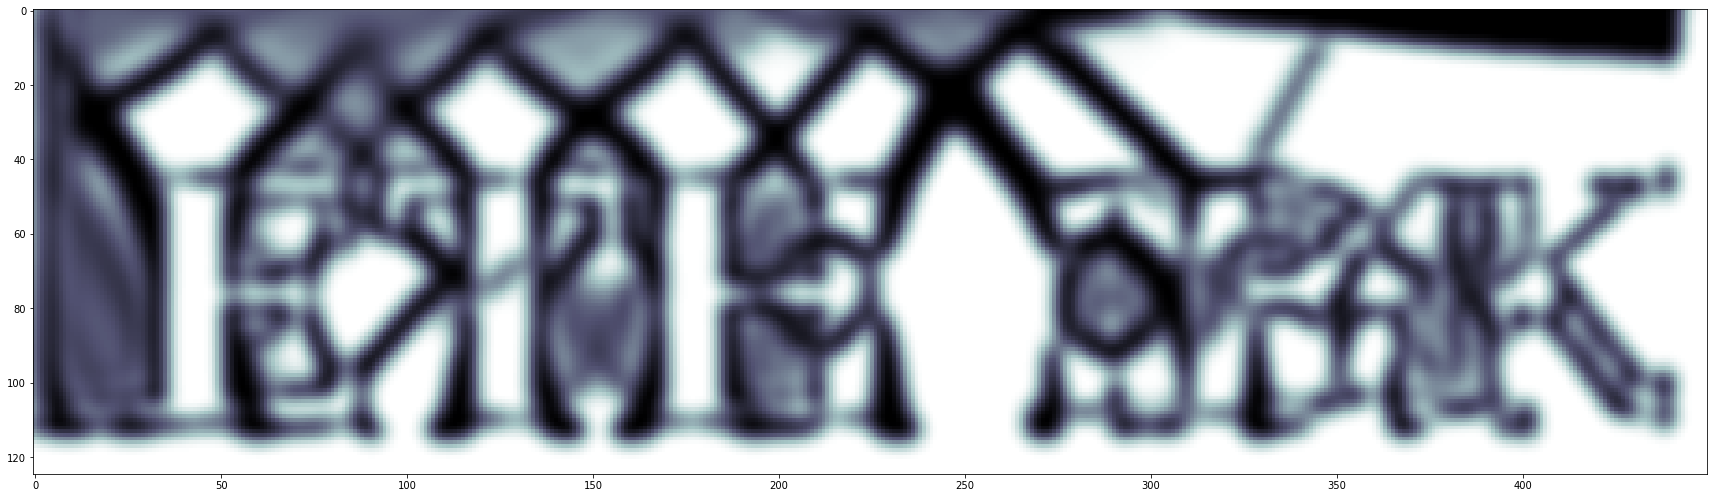

it.: 19 , obj.: 9798470.753 Vol.: 0.400, ch.: 0.168


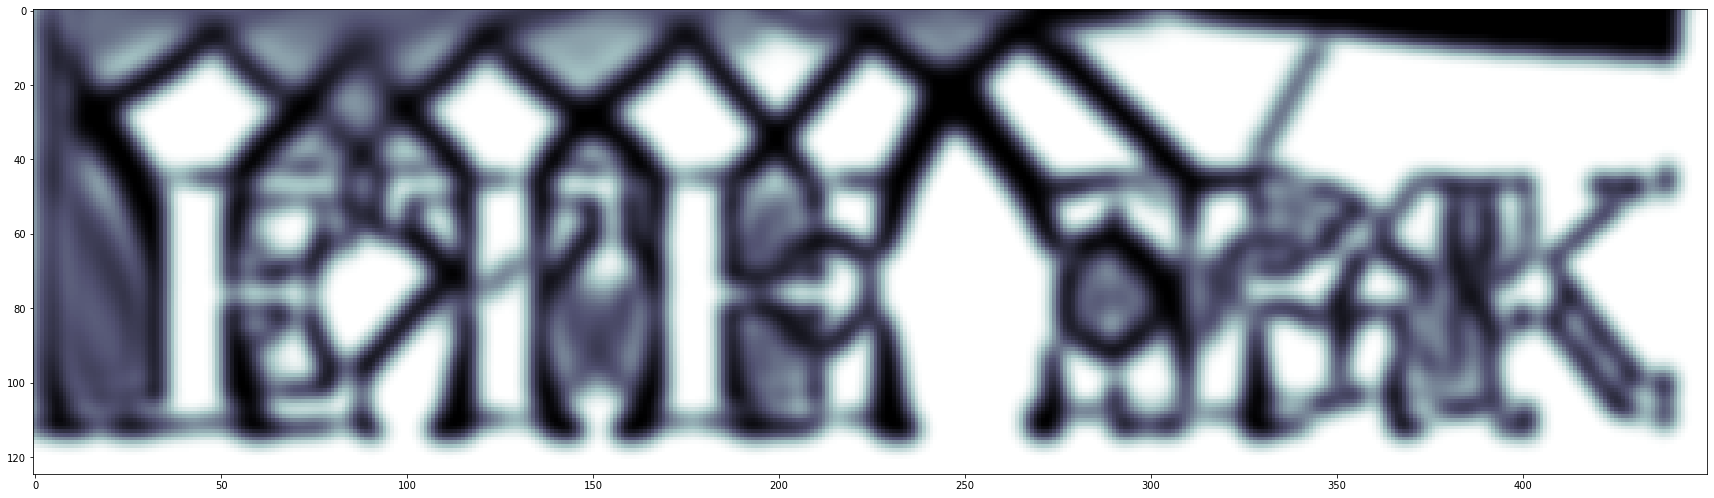

it.: 20 , obj.: 9726209.748 Vol.: 0.400, ch.: 0.145


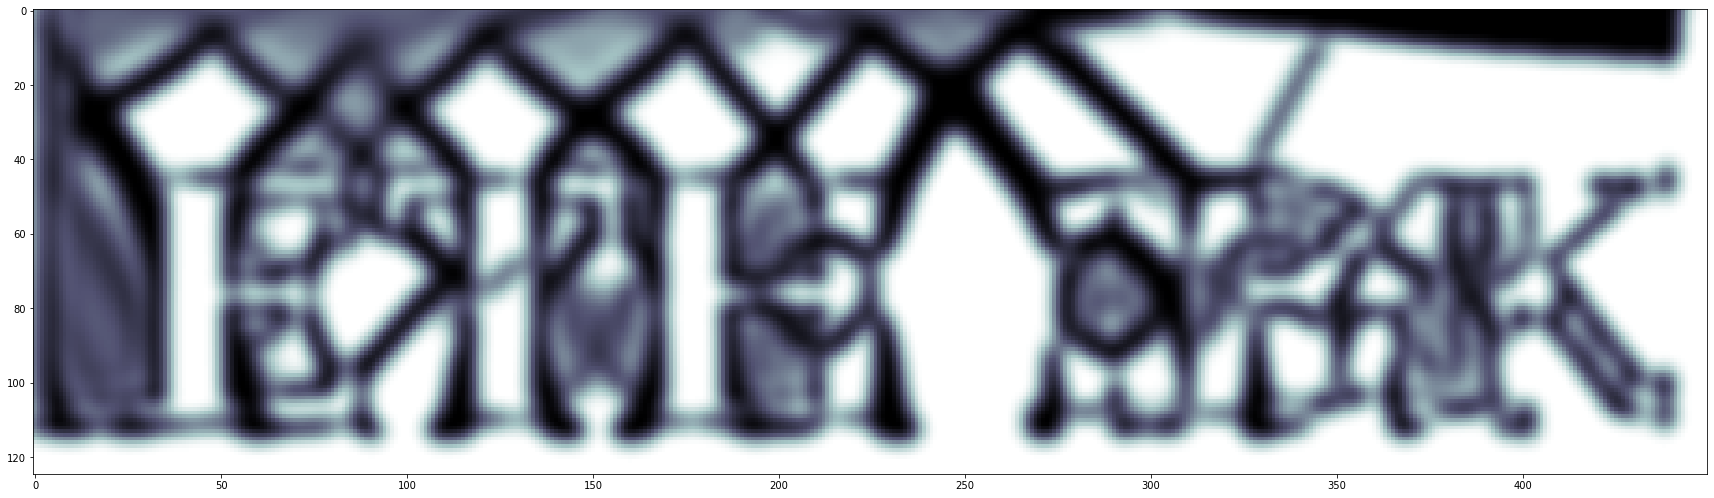

it.: 21 , obj.: 9667919.743 Vol.: 0.400, ch.: 0.145


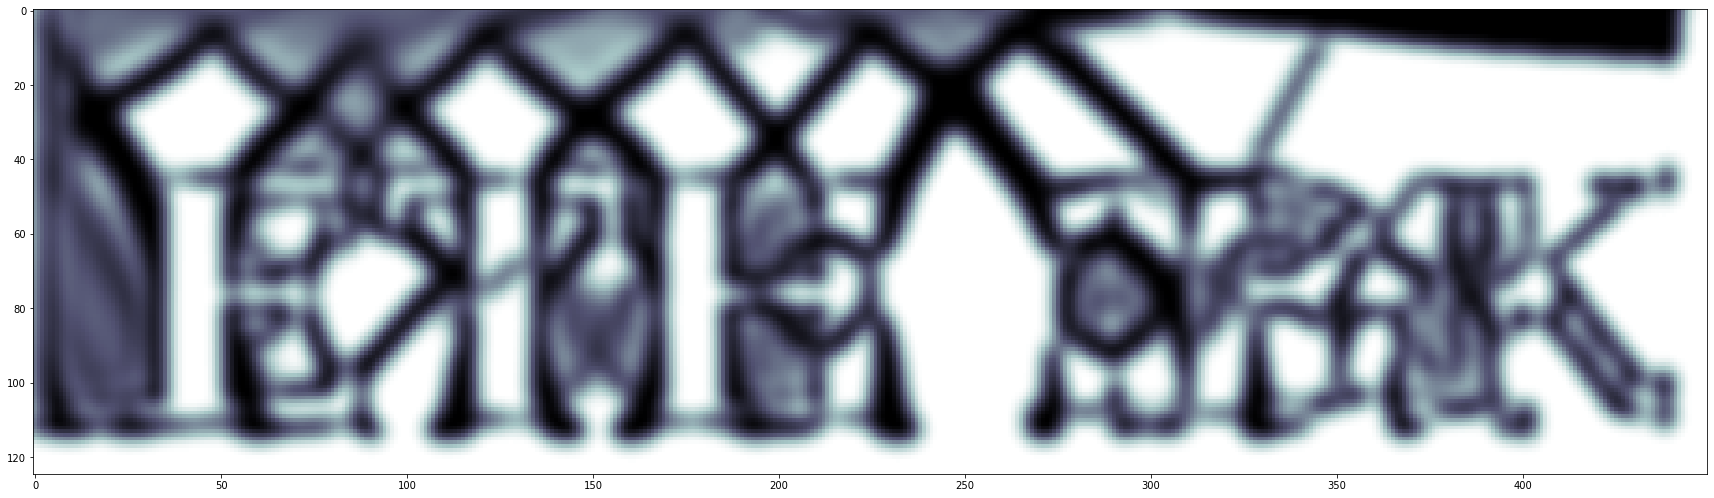

it.: 22 , obj.: 9626402.931 Vol.: 0.400, ch.: 0.148


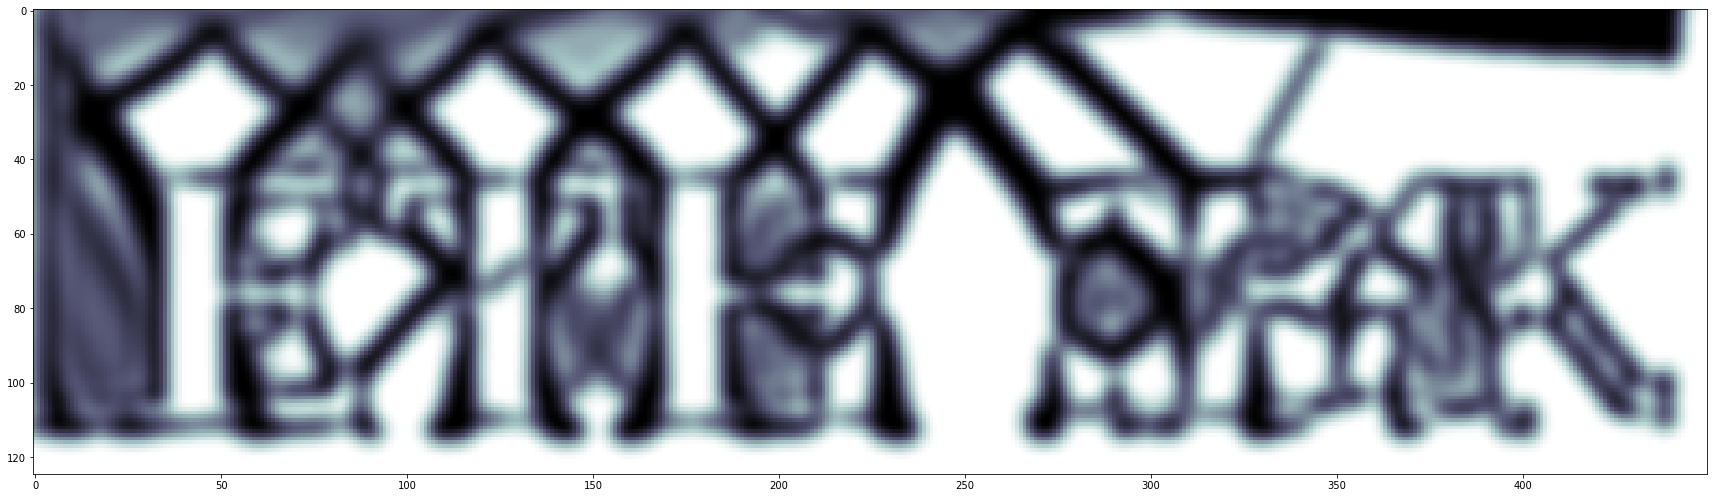

it.: 23 , obj.: 9595726.859 Vol.: 0.400, ch.: 0.142


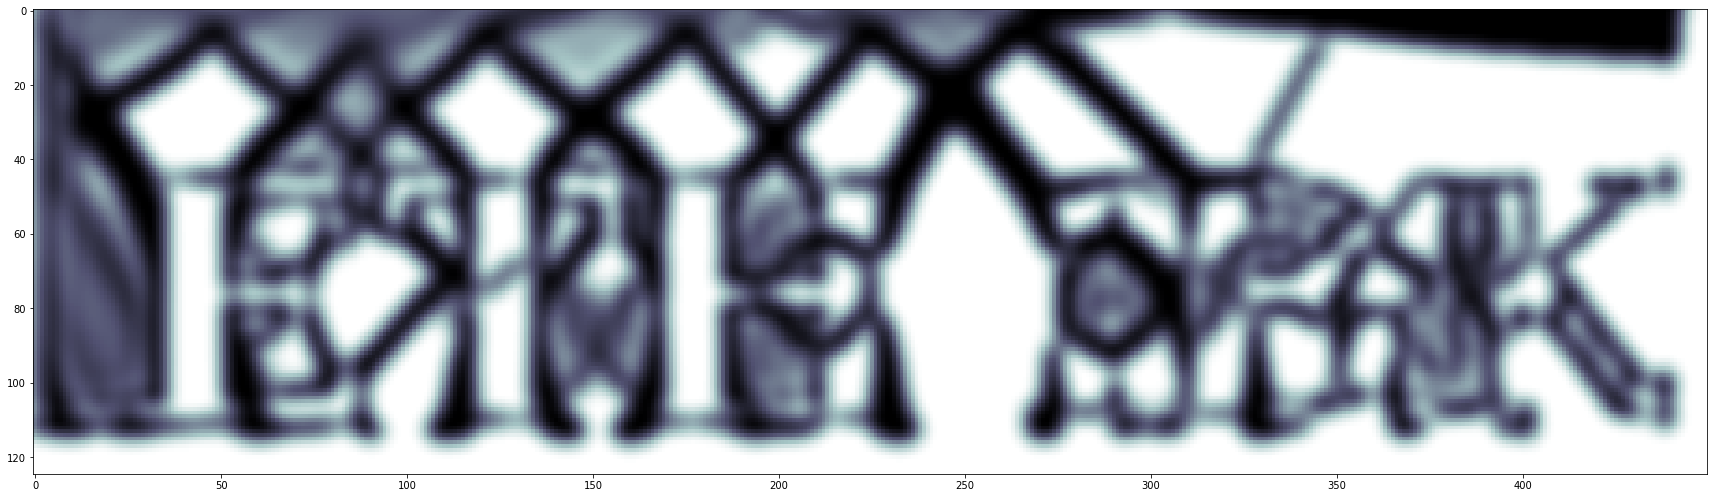

it.: 24 , obj.: 9558944.693 Vol.: 0.400, ch.: 0.138


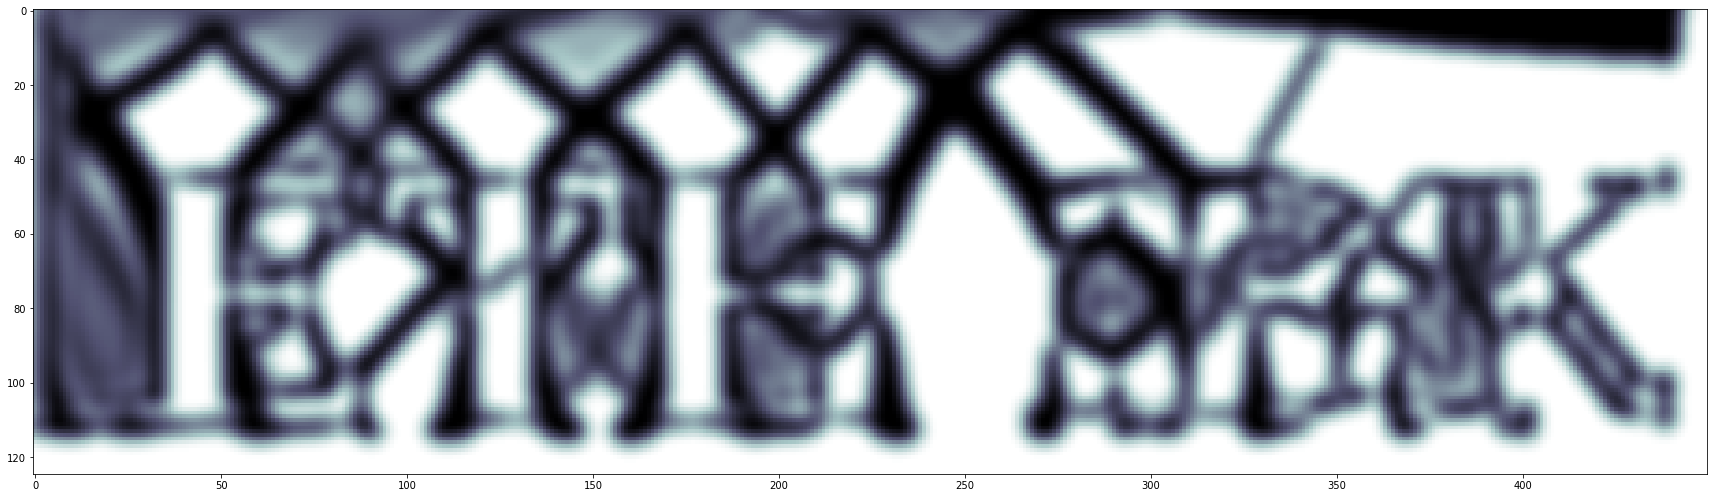

it.: 25 , obj.: 9523356.467 Vol.: 0.400, ch.: 0.130


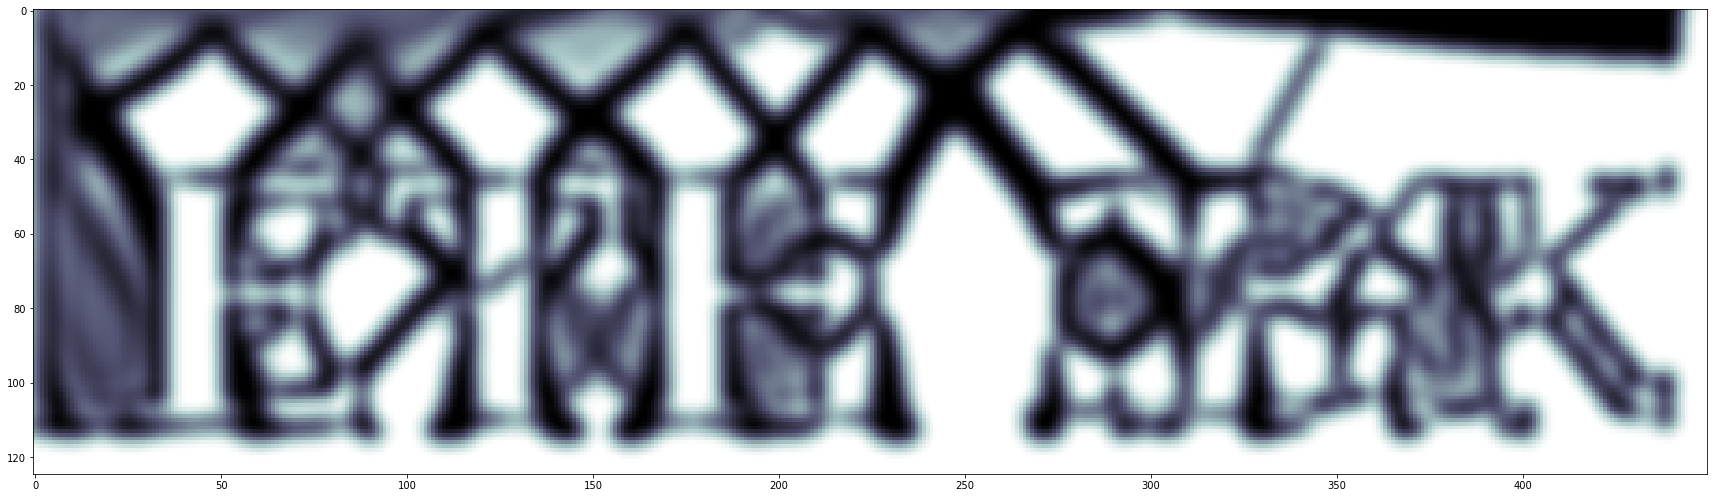

it.: 26 , obj.: 9496729.812 Vol.: 0.400, ch.: 0.124


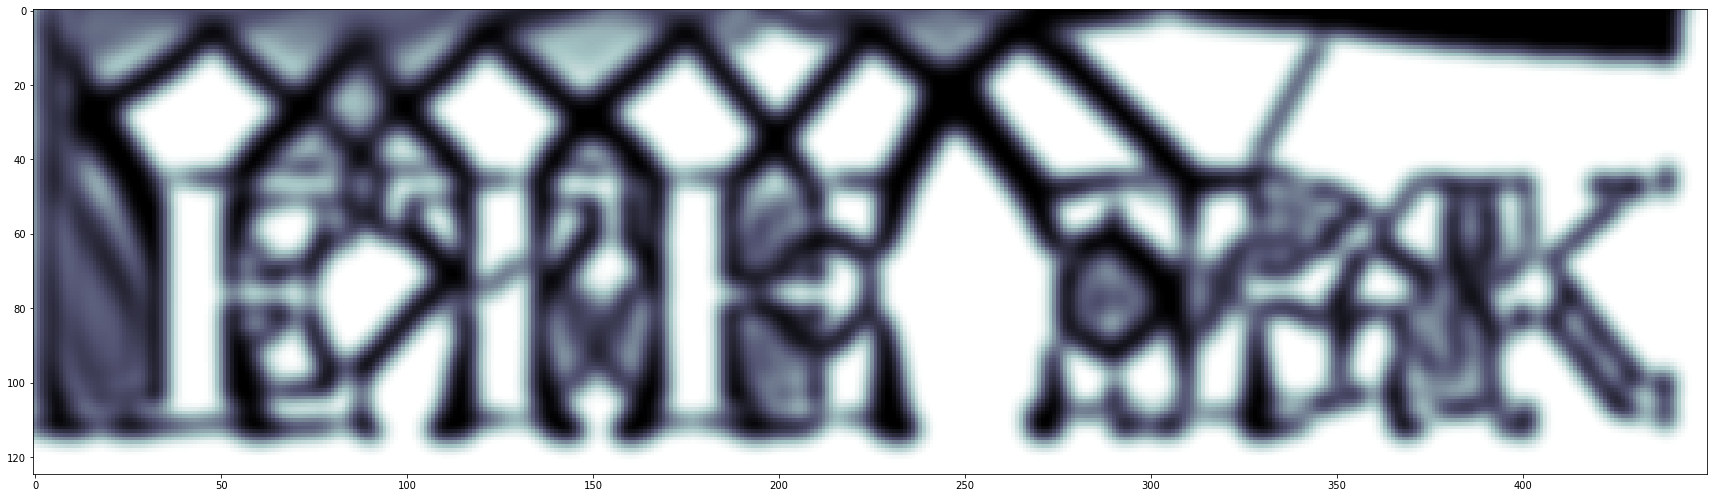

it.: 27 , obj.: 9469729.078 Vol.: 0.400, ch.: 0.138


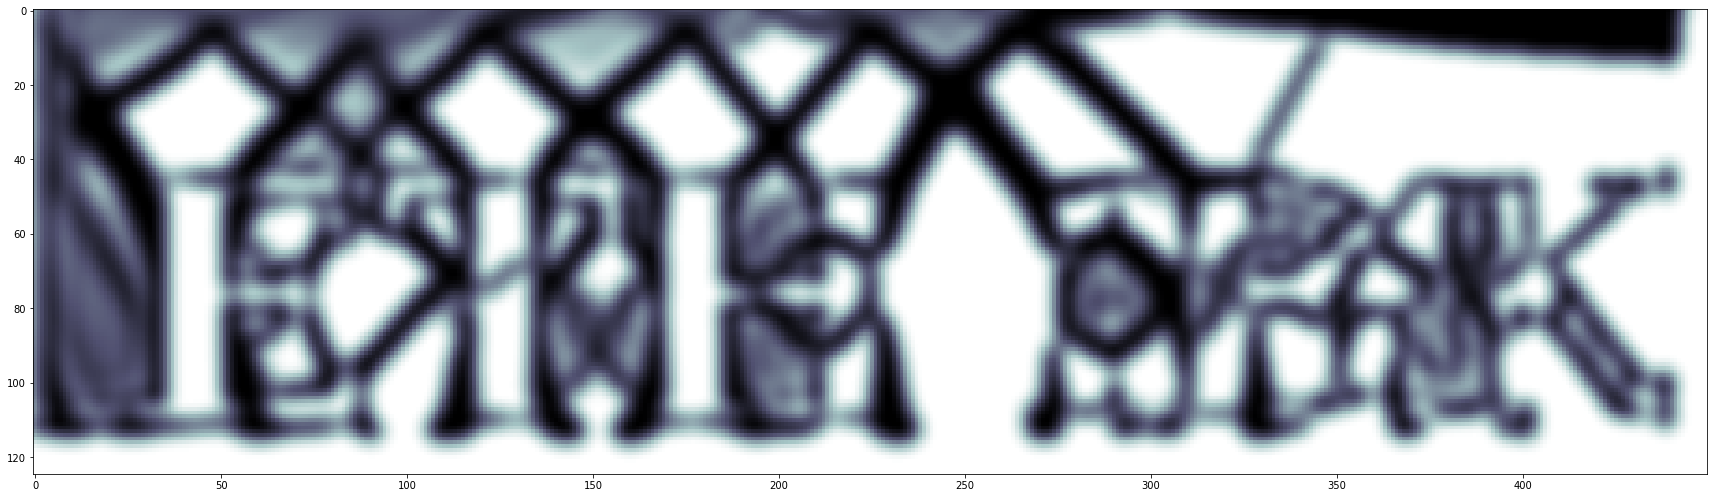

it.: 28 , obj.: 9450476.962 Vol.: 0.400, ch.: 0.124


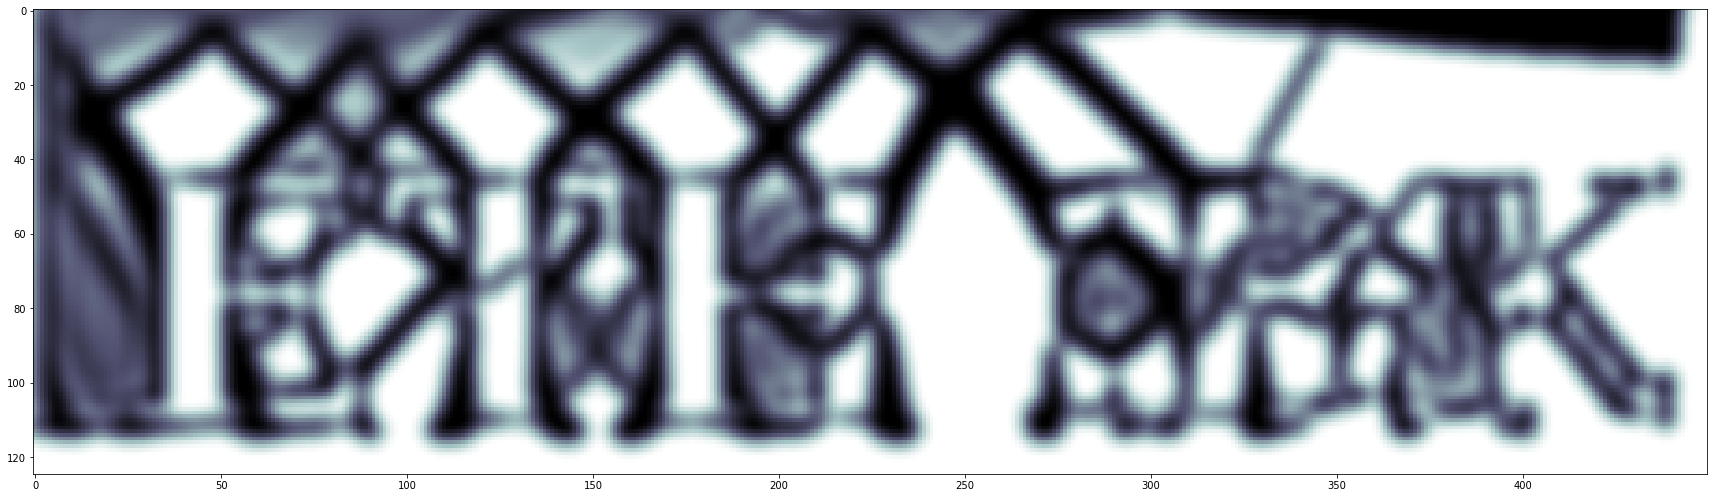

it.: 29 , obj.: 9436654.177 Vol.: 0.400, ch.: 0.140


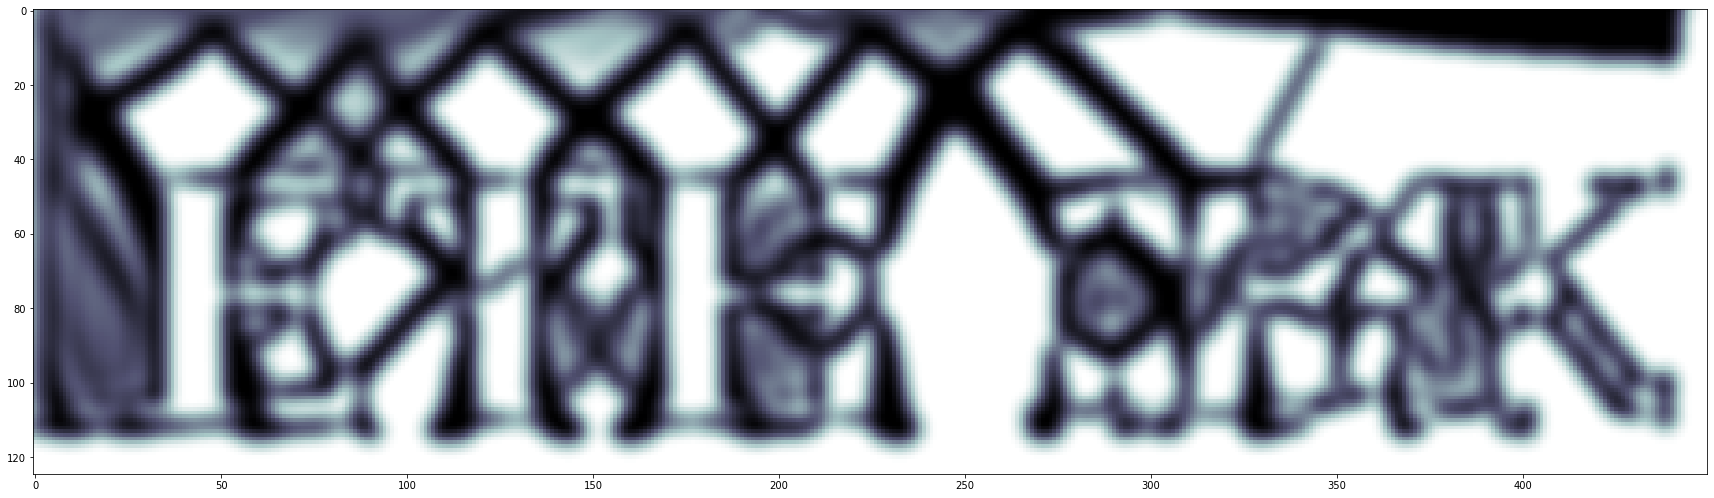

it.: 30 , obj.: 9419274.855 Vol.: 0.400, ch.: 0.124


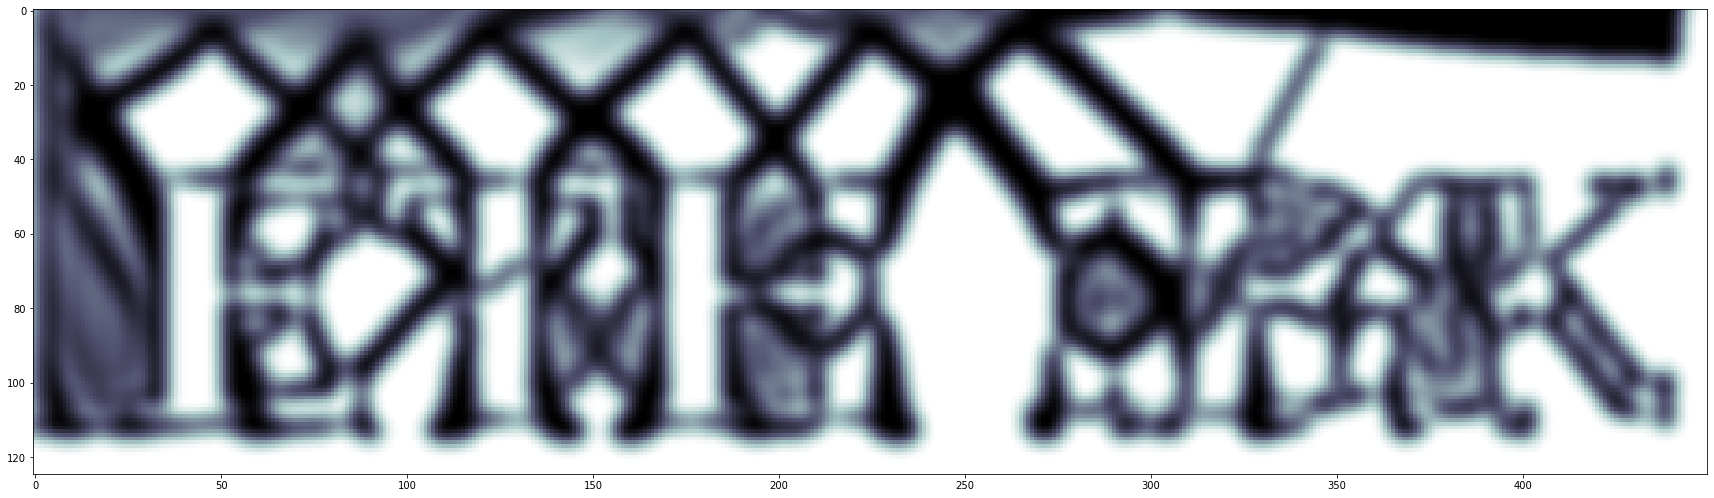

it.: 31 , obj.: 9391133.595 Vol.: 0.400, ch.: 0.118


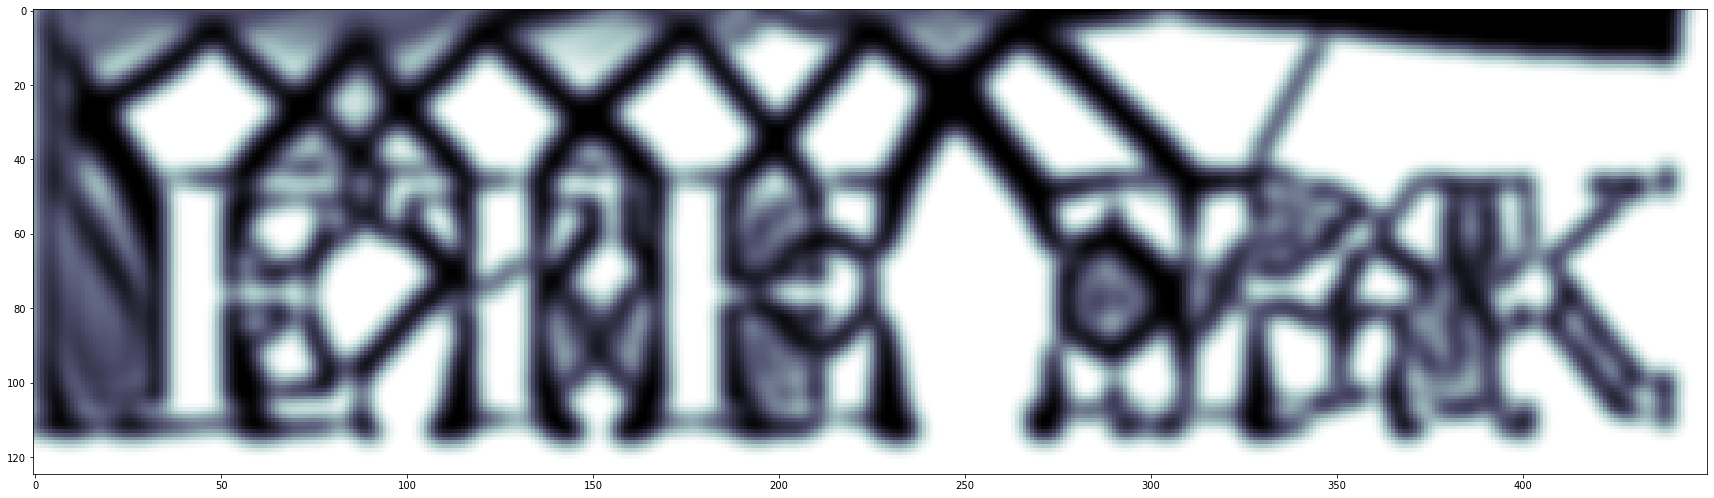

it.: 32 , obj.: 9378407.078 Vol.: 0.400, ch.: 0.120


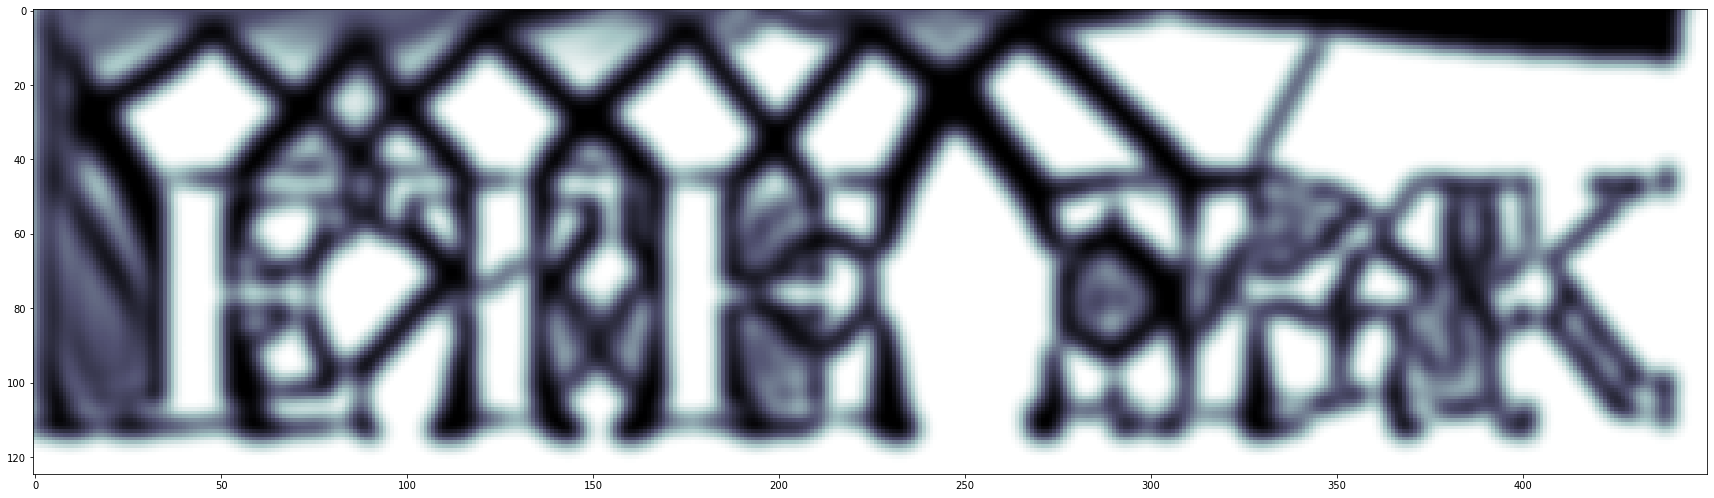

it.: 33 , obj.: 9361010.525 Vol.: 0.400, ch.: 0.105


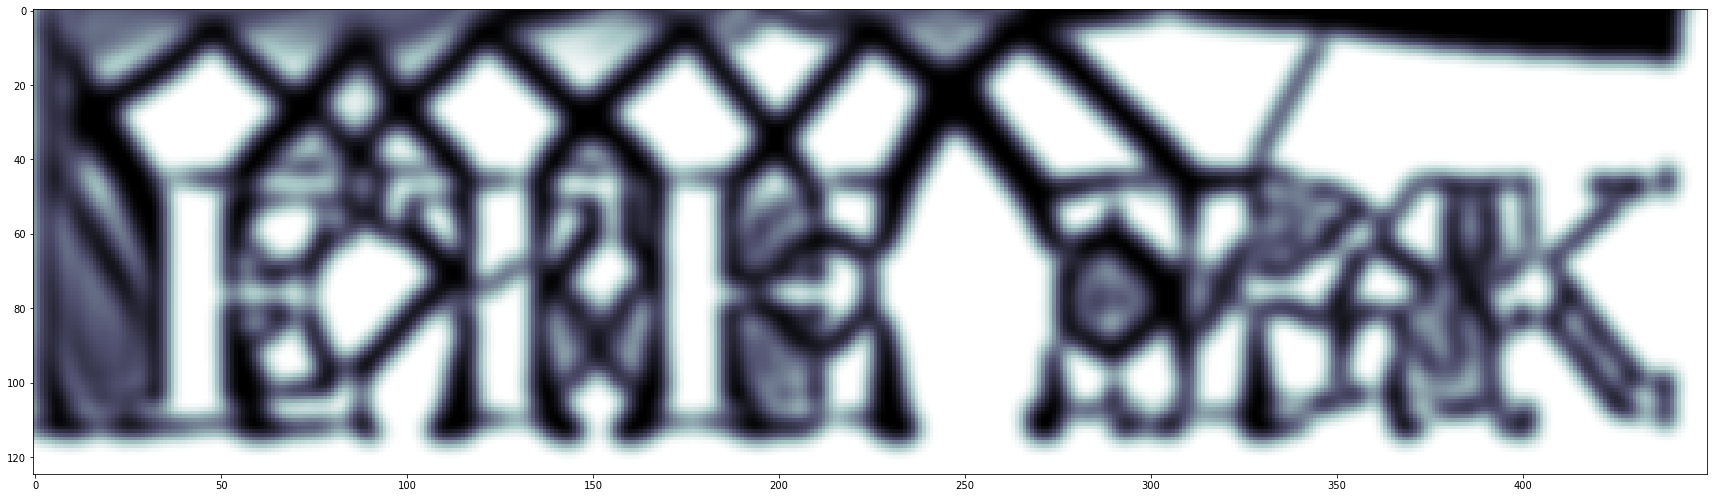

it.: 34 , obj.: 9347990.137 Vol.: 0.400, ch.: 0.124


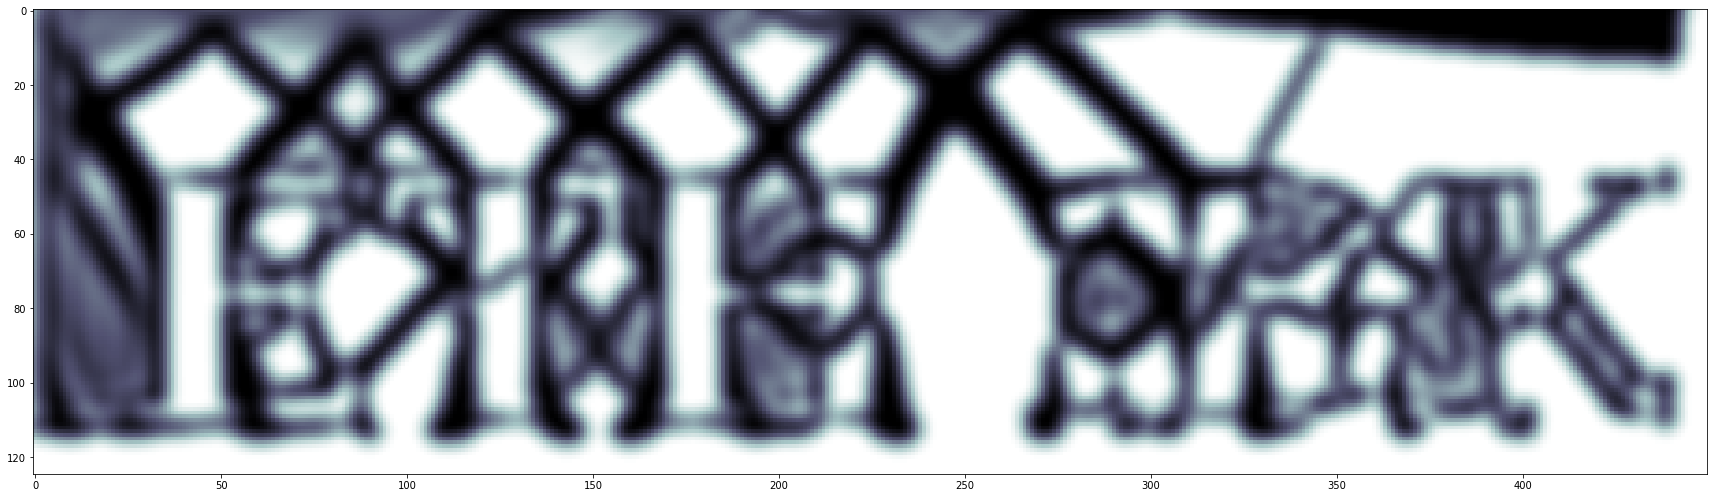

it.: 35 , obj.: 9332310.246 Vol.: 0.400, ch.: 0.130


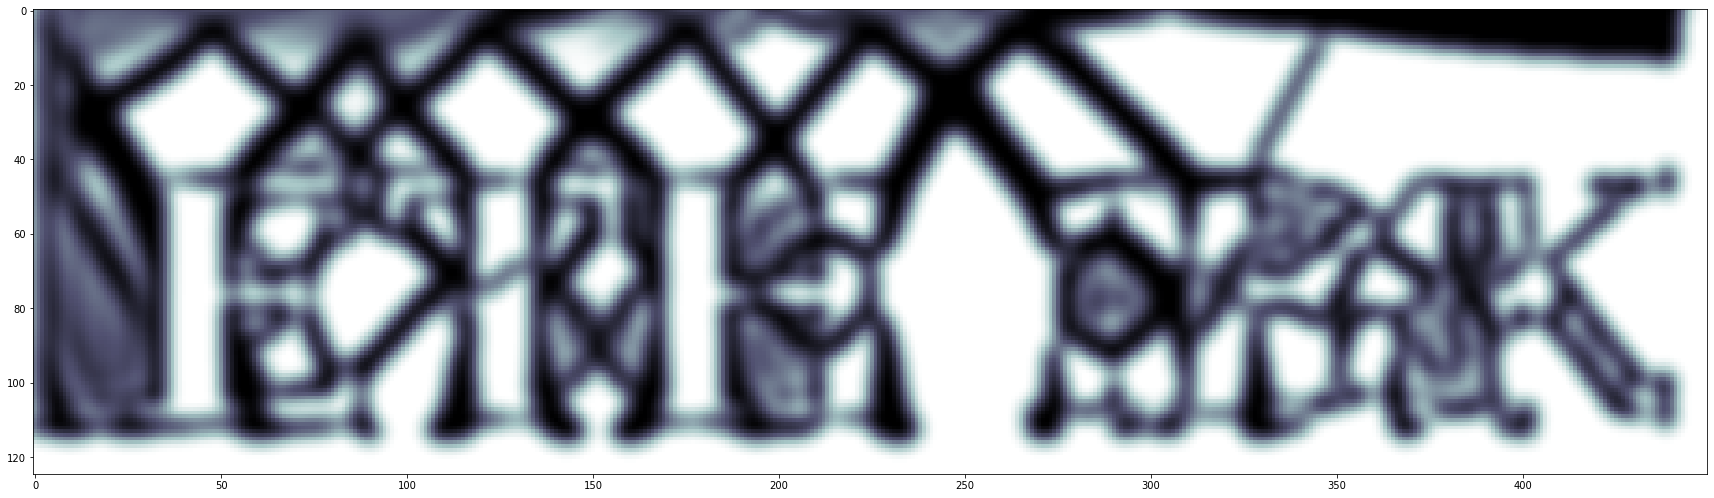

it.: 36 , obj.: 9317951.750 Vol.: 0.400, ch.: 0.134


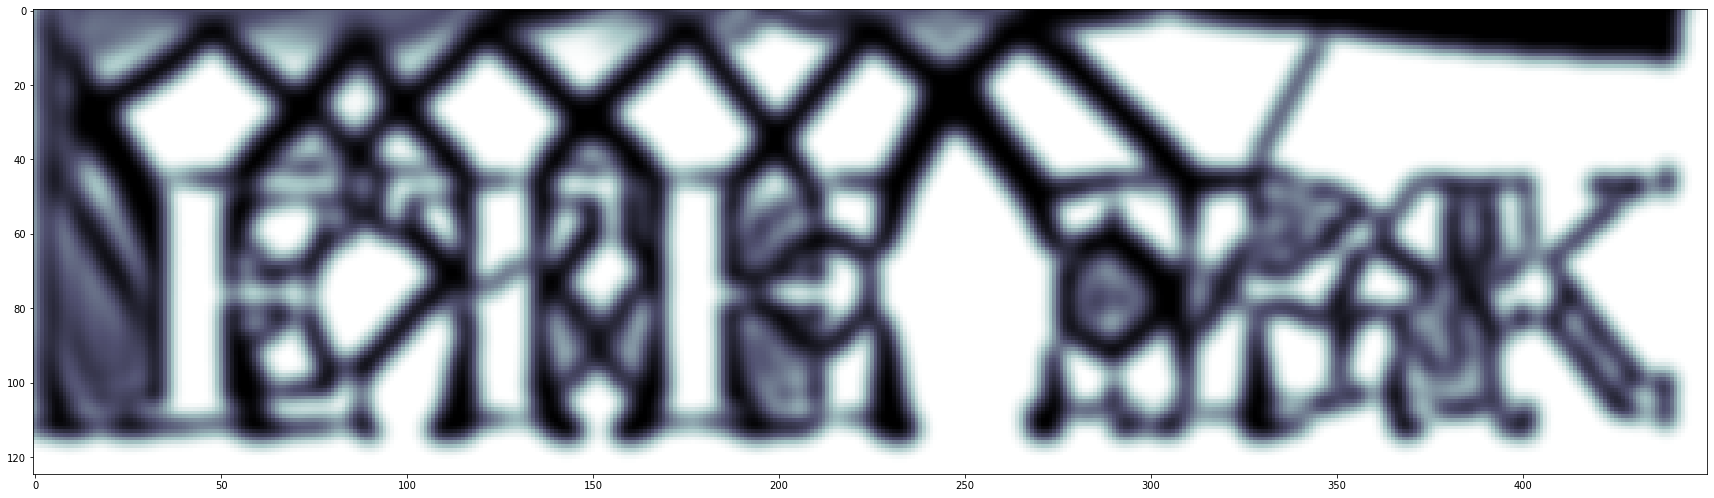

it.: 37 , obj.: 9302666.590 Vol.: 0.400, ch.: 0.110


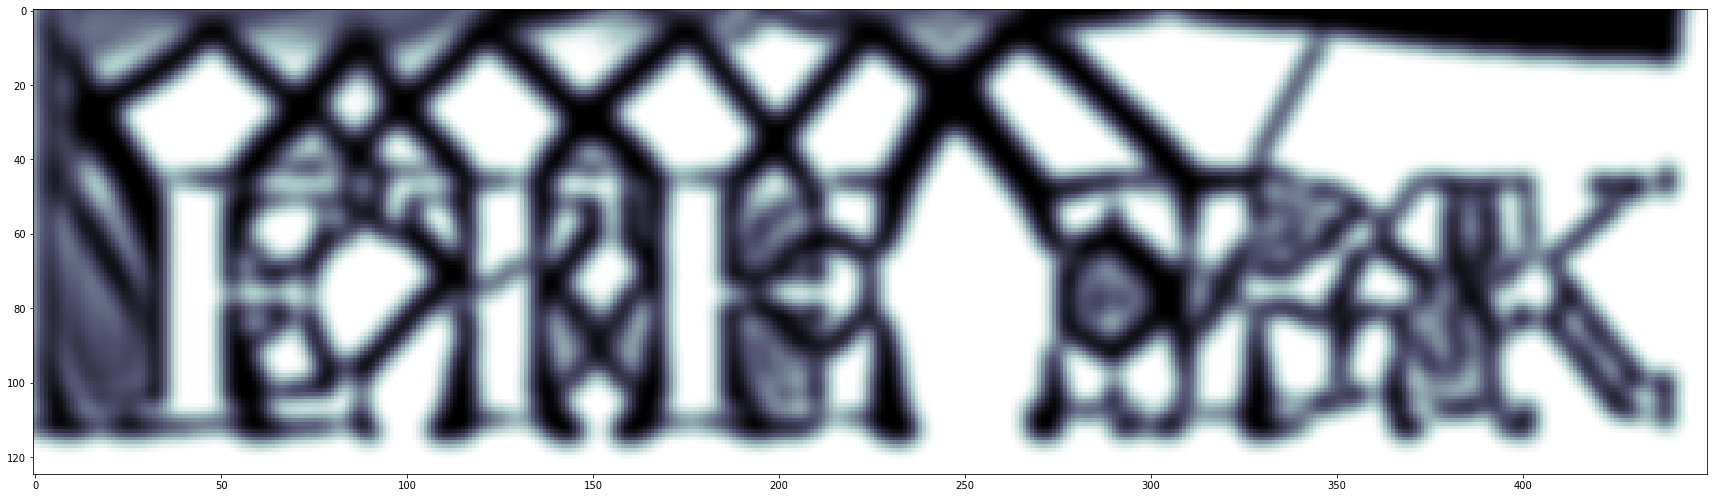

it.: 38 , obj.: 9302056.261 Vol.: 0.400, ch.: 0.091


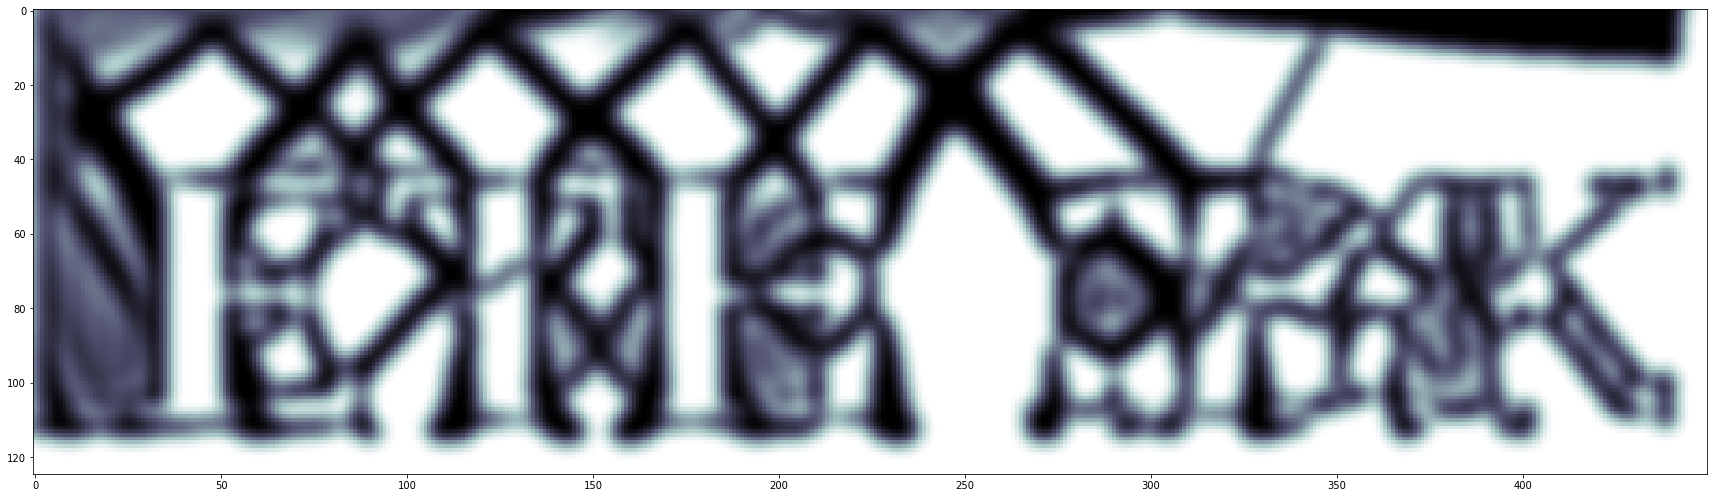

it.: 39 , obj.: 9287161.709 Vol.: 0.400, ch.: 0.102


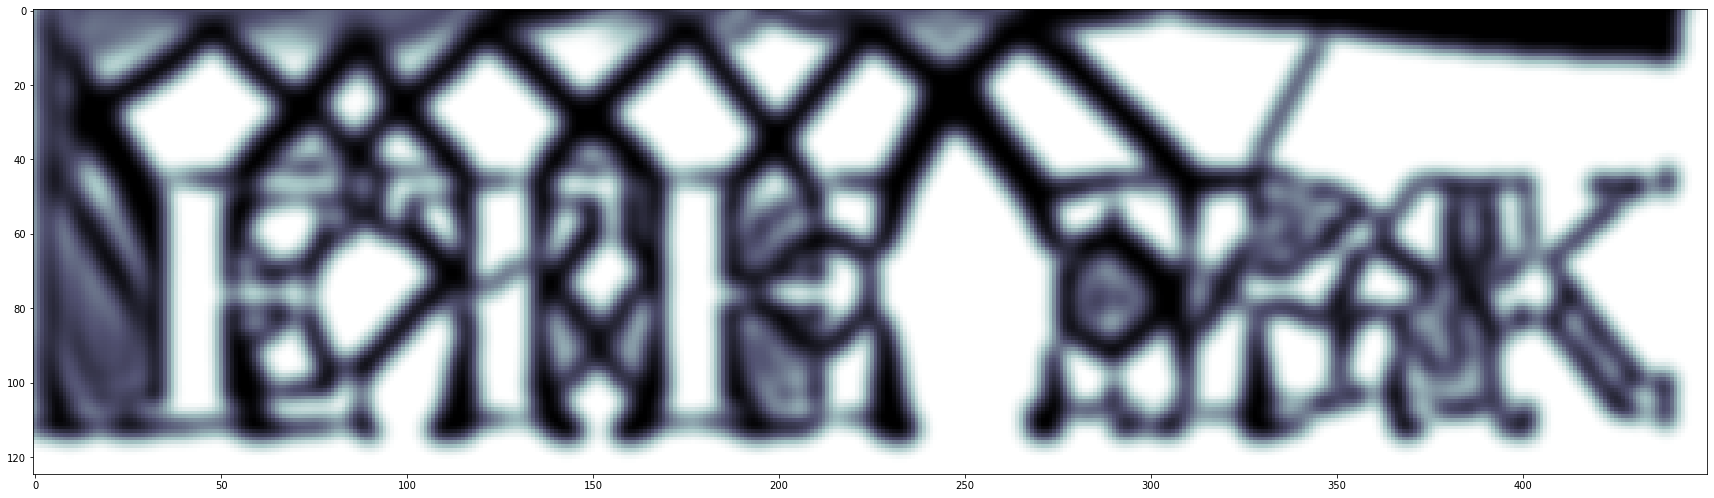

it.: 40 , obj.: 9276092.545 Vol.: 0.400, ch.: 0.117


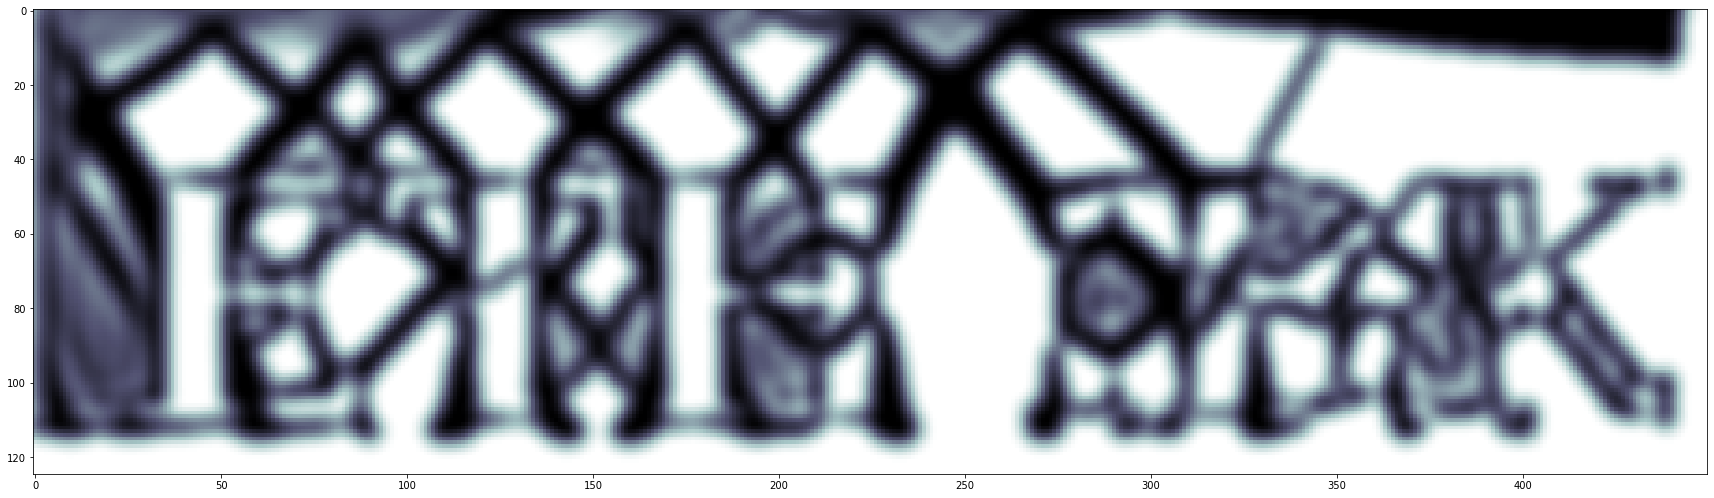

it.: 41 , obj.: 9261217.459 Vol.: 0.400, ch.: 0.136


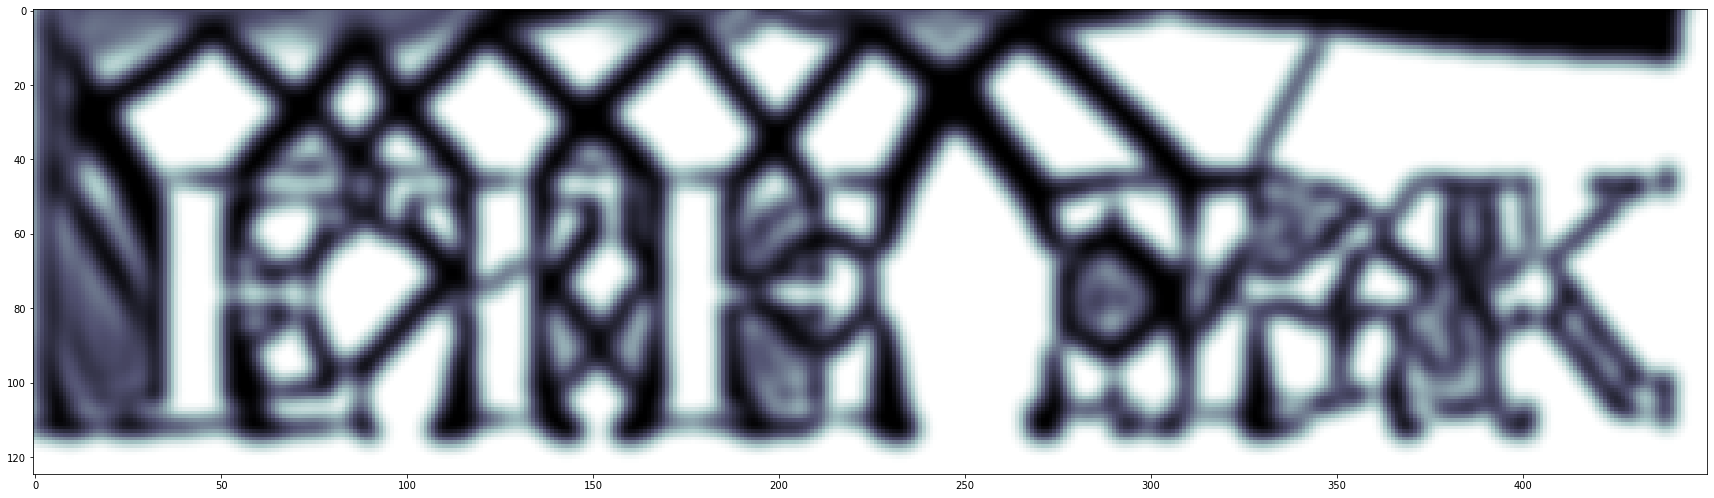

it.: 42 , obj.: 9259889.230 Vol.: 0.400, ch.: 0.098


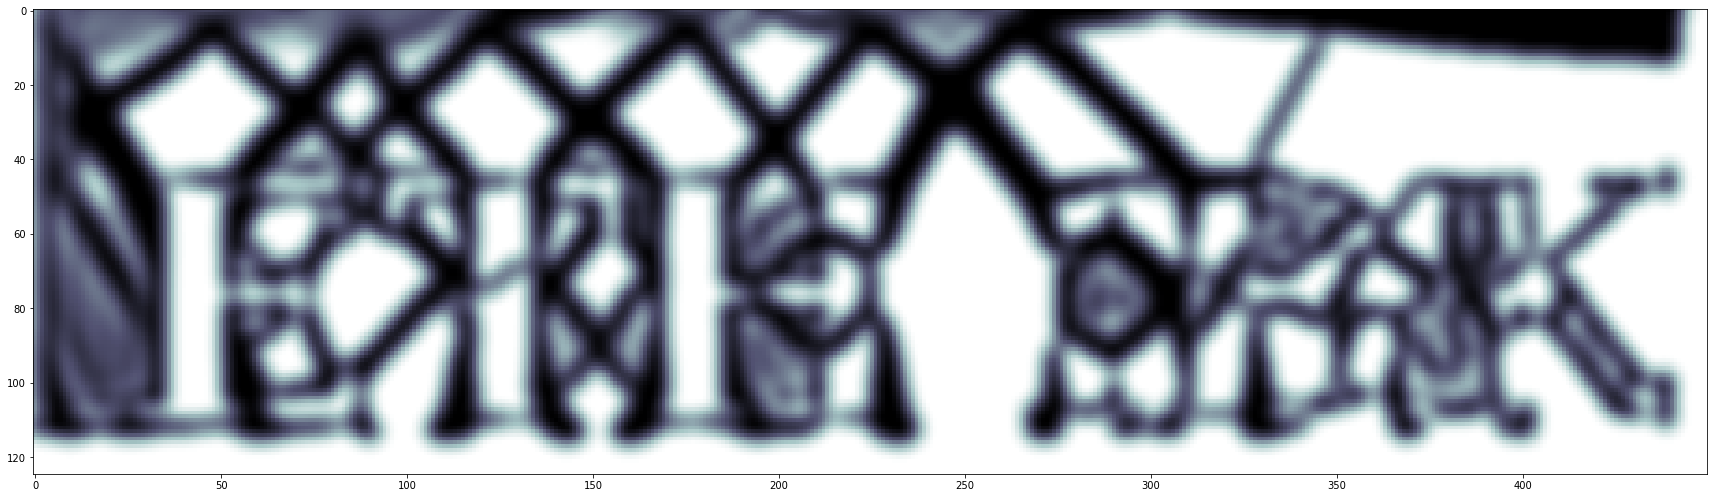

it.: 43 , obj.: 9244755.682 Vol.: 0.400, ch.: 0.099


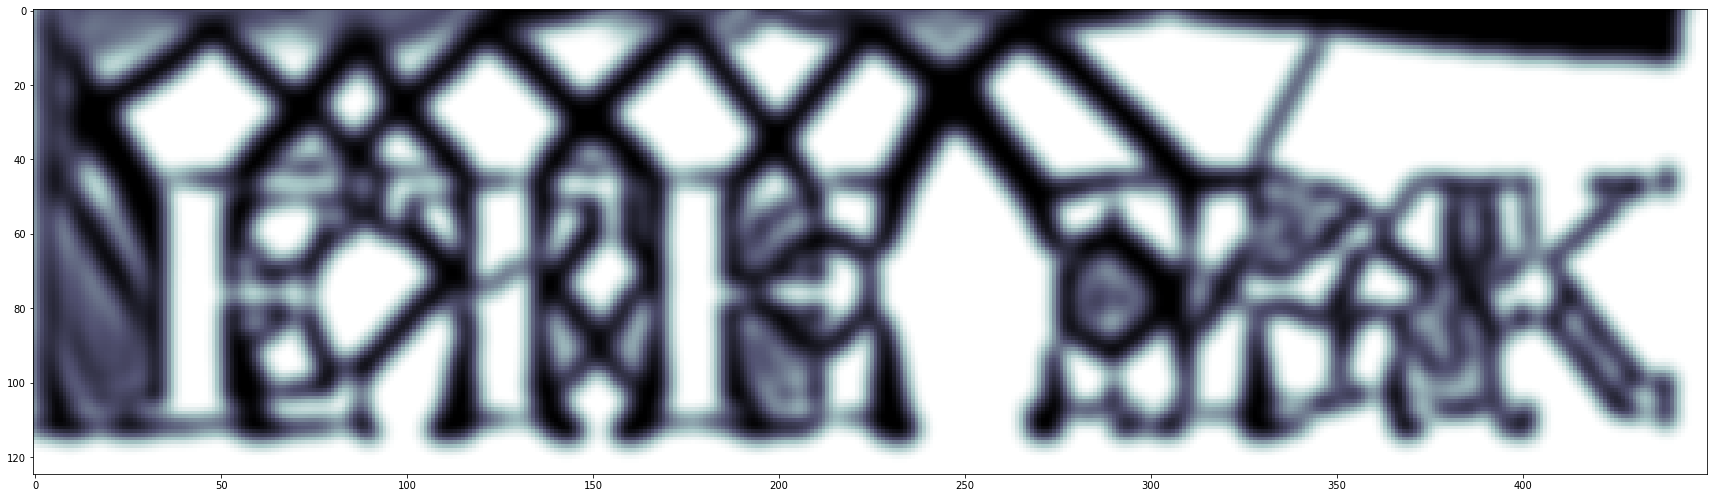

it.: 44 , obj.: 9244475.898 Vol.: 0.400, ch.: 0.087


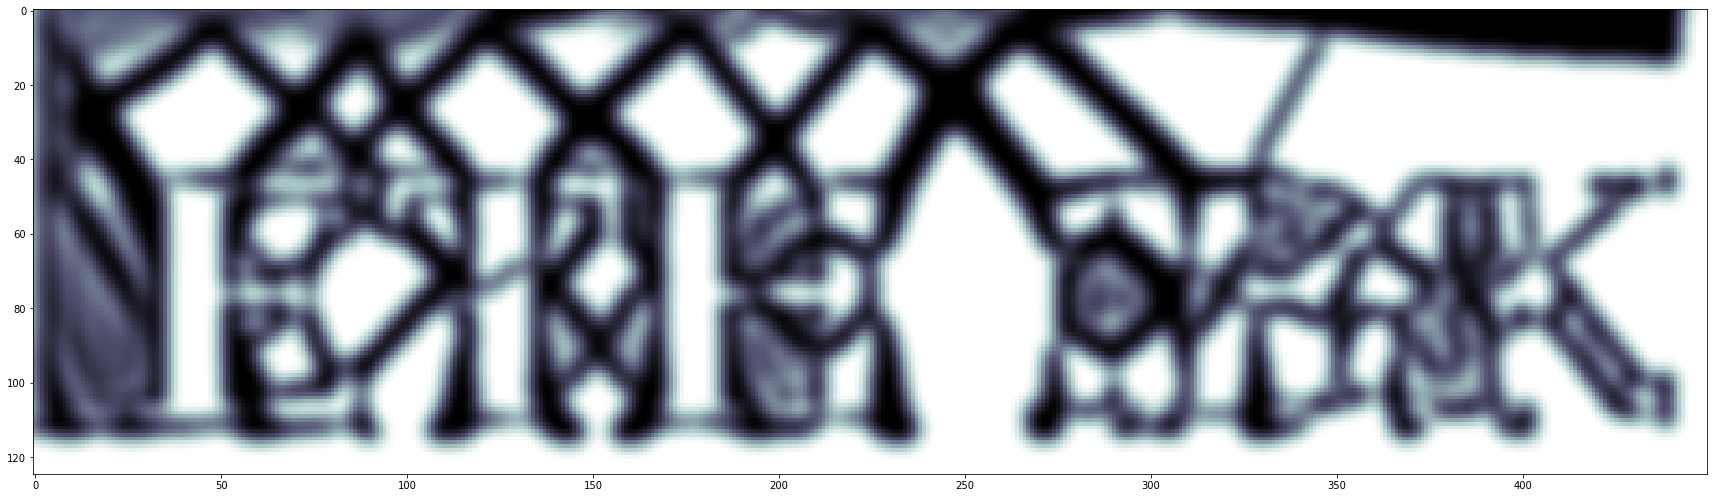

it.: 45 , obj.: 9240673.129 Vol.: 0.400, ch.: 0.099


In [ ]:
loop=0
change=1
dv = np.ones(nely*nelx)
dc = np.ones(nely*nelx)
ce = np.ones(nely*nelx)
obj_hist = []

while change>0.01 and loop<2000:
    loop=loop+1
    # Setup and solve FE problem
    sK=((KE.flatten()[np.newaxis]).T*(Emin+(xPhys)**penal*(Emax-Emin))).flatten(order='F')
    K = coo_matrix((sK,(iK,jK)),shape=(ndof,ndof)).tocsc()
    # Remove constrained dofs from matrix
    K = K[free,:][:,free]
    # Solve system 
    u[free,0]=spsolve(K,f[free,0])    
    # Objective and sensitivity
    ce[:] = (np.dot(u[edofMat].reshape(nelx*nely,8),KE) * u[edofMat].reshape(nelx*nely,8) ).sum(1)
    obj=( (Emin+xPhys**penal*(Emax-Emin))*ce ).sum()
    dc[:]=(-penal*xPhys**(penal-1)*(Emax-Emin))*ce
    dv[:] = np.ones(nely*nelx)
    # Sensitivity filtering:
    if ft==0:
        dc[:] = np.asarray((H*(x*dc))[np.newaxis].T/Hs)[:,0] / np.maximum(0.001,x)
    elif ft==1:
        dc[:] = np.asarray(H*(dc[np.newaxis].T/Hs))[:,0]
        dv[:] = np.asarray(H*(dv[np.newaxis].T/Hs))[:,0]
    # Optimality criteria
    xold[:]=x
    (x[:],g)=oc(nelx,nely,x,volfrac,dc,dv,g)
    # Filter design variables
    if ft==0:   xPhys[:]=x
    elif ft==1:    xPhys[:]=np.asarray(H*x[np.newaxis].T/Hs)[:,0]
    # Compute the change by the inf. norm
    change=np.linalg.norm(x.reshape(nelx*nely,1)-xold.reshape(nelx*nely,1),np.inf)
    # Plot to screen
    #im.set_array(-xPhys.reshape((nelx,nely)).T)
    #fig.canvas.draw()
    #pplot.subplot(1,3,1)
    pplot.figure(figsize = (30,10))
    pplot.imshow(-xPhys.reshape((nelx,nely)), cmap = "bone")
    pplot.savefig('step_%04i.png'%loop)

    pplot.plot(obj_hist);
    pplot.show()
    
    # Write iteration history to screen (req. Python 2.6 or newer)
    print("it.: {0} , obj.: {1:.3f} Vol.: {2:.3f}, ch.: {3:.3f}".format(\
                loop,obj,(g+volfrac*nelx*nely)/(nelx*nely),change))